In [263]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:,.0f}'.format)

# Reading the file

In [264]:
# Read the CSV file into a DataFrame
df = pd.read_csv('/Users/maggiehuang/Desktop/INSY662_Data_Mining_and_Visualization_for_Analytic/INSY662-Data-Mining-and-Visualization-Project/Toronto_Fire_incidents_w_Dist_Incds_map.csv')

# Display the first few rows of the DataFrame
df.head()

,_id_x,Area_of_Origin,Building_Status,Business_Impact,Civilian_Casualties,Count_of_Persons_Rescued,Estimated_Dollar_Loss,Estimated_Number_Of_Persons_Displaced,Exposures,Ext_agent_app_or_defer_time,Extent_Of_Fire,Final_Incident_Type,Fire_Alarm_System_Impact_on_Evacuation,Fire_Alarm_System_Operation,Fire_Alarm_System_Presence,Fire_Under_Control_Time,Ignition_Source,Incident_Number,Incident_Station_Area,Incident_Ward,Initial_CAD_Event_Type,Intersection,Last_TFS_Unit_Clear_Time,Latitude,Level_Of_Origin,Longitude,Material_First_Ignited,Method_Of_Fire_Control,Number_of_responding_apparatus,Number_of_responding_personnel,Possible_Cause,Property_Use,Smoke_Alarm_at_Fire_Origin,Smoke_Alarm_at_Fire_Origin_Alarm_Failure,Smoke_Alarm_at_Fire_Origin_Alarm_Type,Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation,Smoke_Spread,Sprinkler_System_Operation,Sprinkler_System_Presence,Status_of_Fire_On_Arrival,TFS_Alarm_Time,TFS_Arrival_Time,TFS_Firefighter_Casualties,Response_Time_Seconds,_id_y,ADDRESS_POINT_ID,ADDRESS_NUMBER,LINEAR_NAME_FULL,ADDRESS,MUNICIPALITY_NAME,CENTRELINE_ID,OBJECTID,ID,STATION,YEAR_BUILD,WARD,WARD_NAME,TYPE_DESC,PUBLIC_ED_OFFICE,FIRE_PREV_OFFICE,FIRE_OTHER,geometry,Combined_Address,station_longitude,station_latitude,distance_from_nearest_station,time_from_nearest_station,response_delay,Mapped_Initial_CAD_Event_Type
0,3692996,81 - Engine Area,NaN,NaN,0,0,"15,000",NaN,NaN,2018-02-24T21:12:00,NaN,01 - Fire,NaN,NaN,NaN,2018-02-24T21:15:40,999 - Undetermined,F18020956,441,1,Vehicle Fire,Dixon Rd / 427 N Dixon Ramp,2018-02-24T21:38:31,44,NaN,-80,47 - Vehicle,1 - Extinguished by fire department,1,4,99 - Undetermined,"896 - Sidewalk, street, roadway, highway, hwy ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,"7 - Fully involved (total structure, vehicle, ...",2018-02-24 21:04:29,2018-02-24 21:10:11,0,342,99,6044964,947,Martin Grove Rd,947 Martin Grove Rd,Etobicoke,6044958,4653861,6,441,1964,1,Etobicoke North,Fire Station,NaN,NaN,West Training Centre / Fire Training Tower,"{'type': 'MultiPoint', 'coordinates': [[-79.57...","947 Martin Grove Rd, Etobicoke",-80,44,"6,297",507,-165,Vehicle Fire
1,3692997,"75 - Trash, rubbish area (outside)",NaN,NaN,0,0,50,NaN,NaN,2018-02-24T21:29:42,NaN,01 - Fire,NaN,NaN,NaN,2018-02-24T21:32:24,999 - Undetermined,F18020969,116,18,Fire - Grass/Rubbish,Sheppard Ave E / Clairtrell Rd,2018-02-24T21:35:58,44,NaN,-79,97 - Other,1 - Extinguished by fire department,1,4,03 - Suspected Vandalism,"896 - Sidewalk, street, roadway, highway, hwy ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 - Fire with no evidence from street,2018-02-24 21:24:43,2018-02-24 21:29:31,0,288,41,8731578,255,Esther Shiner Blvd,255 Esther Shiner Blvd,North York,30005958,2607109,1,116,2007,17,Don Valley North,Fire Station,NaN,"Fire Prevention Office (E, N)",Division Commander / Platoon Chiefs,"{'type': 'MultiPoint', 'coordinates': [[-79.36...","255 Esther Shiner Blvd, North York",-79,44,"2,721",283,5,Fire - Grass/Rubbish
2,3692998,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,"03 - NO LOSS OUTDOOR fire (exc: Sus.arson,vand...",NaN,NaN,NaN,NaN,NaN,F18021182,221,21,Fire - Highrise Residential,Danforth Rd / Savarin St,2018-02-25T14:14:03,44,NaN,-79,NaN,NaN,6,22,NaN,891 - Outdoor general auto parking,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-02-25 13:29:59,2018-02-25 13:36:49,0,410,22,330710,2575,Eglinton Ave E,2575 Eglinton Ave E,Scarborough,111065,2048861,95,221,2014,20,Scarborough Southwest,Fire Station,NaN,NaN,Division Commander / Platoon Chiefs,"{'type': 'MultiPoint', 'coordinates': [[-79.25...","2575 Eglinton Ave E, Scarborough",-79,44,"1,579",244,166,Fire - Highrise Residential
3,3692999,"75 - Trash, rubbish area (outside)",01 - Normal (no change),1 - No business interruption,0,0,0,0,NaN,2018-02-25T14:19:25,1 - Confined to object of origin,01 - Fire,9 - Undetermined,8 - Not applicable (no system),9 - Undetermined,2018-02-25T14:20:00,999 - Undetermined,F18021192,133,5,Fire - Commercial/Industrial,Keele St / Lawrence Ave W,2018-02-25T15:07:42,44,999,-79,99 - Undetermin

# Removing rows where Final_Incident_Type is No Loss Outdoor, since we want only those cases where there was a Loss.

In [265]:
df['Final_Incident_Type'].unique()

array(['01 - Fire',
       '03 - NO LOSS OUTDOOR fire (exc: Sus.arson,vandal,child playing,recycling or dump fires)',
       '02 - Explosion (including during Fire, excluding Codes 3 & 11-13)'],
      dtype=object)

In [266]:
df = df[df['Final_Incident_Type'] != '03 - NO LOSS OUTDOOR fire (exc: Sus.arson,vandal,child playing,recycling or dump fires)']

In [267]:
df['Final_Incident_Type'].unique()

array(['01 - Fire',
       '02 - Explosion (including during Fire, excluding Codes 3 & 11-13)'],
      dtype=object)

# This dataframe place_df contains all the information regarding the place of the fire.

In [268]:
place_df = df[['Area_of_Origin','Building_Status','Business_Impact','Final_Incident_Type','Initial_CAD_Event_Type','Material_First_Ignited','Property_Use','Mapped_Initial_CAD_Event_Type']]

# Categorizing our fire incidents into different categories, so that we can estimate the Fraud Loss appropriately for each category. (This will help to lower our MSE drastically)

In [269]:
# Define function to categorize incidents
def categorize_incident(incident_type):
    if incident_type in ['Alarms Highrise Residential North','Fire Alarm Residential','Fire Highrise Residential North','Alarm Highrise Residential Downtown','Fire - Highrise Residential - Downtown','Alarm Residential','Alarm Highrise Residential','Fire - Highrise Residential','Fire - Residential']:
        return 'Residential'
    elif incident_type in ['Fire Alarm Commercial','Fire - High-Rise Nursing Home','Fire Alarm - High-Rise Nursing Home','Fire Highrise Commercial North','Commercial','Fire Alarm - High-Rise Commercial','Fire - High-Rise Commercial','Alarm Highrise - Commercial - Downtown','Alarm Highrise Commercial','FIHRN', 'FAHRN','Fire - Highrise Commercial - Downtown','Fire - Highrise Commercial','Alarm Commercial/Industrial','Fire - Commercial/Industrial','FIHC', 'FIHCD', 'FAHCD',  'FAWMI', 'COM', 'CONM', 'FACC']:
        return 'Business'
    elif incident_type in ['Vehicle Fire - Natural Gas Vehicle','Vehicle Fire - Hazardous Equipment','Vehicle Fire - Major Vehicle','Vehicle Fire - At Transit','Vehicle Fire - Passenger Incident High-Rise','Vehicle Fire - Threat to Health','Vehicle Fire - Passenger','Fire - Transit Property','Vehicle Fire - Aircraft','Vehicle Fire - Under Control','Fire - High-Rise Vehicle','Vehicle Accident - Trapped - Highway','Vehicle Fire - Highway Elevated','Vehicle - Spill Clean Up','Vehicle Accident - Trapped','Vehicle - Personal Injury','Vehicle - Personal Injury Highway','Vehicle Fire - Underground','Vehicle Accident with Fire','Vehicle Fire - Highway','Vehicle Fire','VEF','VEFH', 'VEFU', 'VEFMV', 'VEPI', 'VEPIH', 'VEAT', 'VEATH', 'VEAF', 'VEFNG']:
        return 'Vehicle'
    elif incident_type in ['Fire Alarm - Working Multiple-Unit Industrial','Industrial Fire Alarm','Fire Alarm - Industrial Dwelling','Industrial Structure Fire','Fire Alarm - Industrial','Fire Alarm - Commercial Industrial','Fire Alarm - Industrial Structure','FIIS','Fire - Industrial Structure','ISFA','Fire - Industrial Dwelling','Fire - Working Multiple-Unit Industrial','FIWMI','Alarm Waterfront Marina/Industrial','Hazmat Level 2','Fire Waterfront Marina/Industrial','Fire - Industrial Incident','Hazmat Level 1','FII', 'FIID', 'ISFI', 'FIWMI', 'FAIS']:
        return 'Industrial'
    elif incident_type in ['Medical Emergency - Unknown','Medical Emergency - Aircraft','Medical - Assist','Public Hazard','Medical Emergency - Critical Incident','Medical Emergency - Cardiac Condition','Medical - VSA','Medical Emergency - Suspicious Condition','Medical Emergency - Tuberculosis','Medical Emergency - Passenger Incident','Medical Emergency - Other','Public Assistance','Fire Alarm - Check Call','Check Call - Non Emergency','Medical - Trouble Breathing','Police Assist','Water Problem','Check Call','Medical - Unconscious','Medical - Other','PA', 'PUB', 'MEO', 'MEU', 'MECR', 'MECC']:
        return 'Public Assistance/Non-Fire'
    elif incident_type in ['Fire - Grass/Rubbish', 'Alarm Single Source','Island Fire Alarm Response','FISD','Fire - Other','Fire - Encampment','Fire Alarm - High-Rise Dwelling','Fire - High-Rise Dwelling','FIHRD', 'FAHRD','Alarm Subway','Water Incident','Fire Alarm System','Fire - Water','Construction/Maintenance Incident','Fire Alarm System - Special Structure','Fire - Chimney','FIG2','FIG','Island - Fire Response','Fire Investigation Unit', 'FIU','Fire - Outside Structure','Fire - Outside','Fire - Inside','Fire Alarm - High-Rise','Fire - High-Rise','Fire','Fire - Transformer/Pole', 'Fire - Hydro Vault','Fire - Subway','FIHV','Fire - Subway - Downtown','Fire - Outside Storage','Wires Down - Hydro','Fire - Alarm Waterfront Highrise','Water Incident - Category 1','Lake Fire Response','Fire - Waterfront']:
        return 'Other'
    elif incident_type in ['Fire - School','Fire - Institution - Downtown','Alarm Institution','Alarm Institution Downtown','Fire - Institution','Alarm - Institution - School','Fire - Institution - School']:
        return 'Institution/School'
    elif incident_type in ['Leak Fire','Carbon Monoxide Notification','Fire - Hazardous Commercial Notified','Residential Elevator Hazard','Hazardous Materials Level 2','Fire Alarm - Hazardous Commercial','Hazardous Materials Level 1','Carbon Monoxide Alarm','Fire - Hazardous Commercial','Carbon Monoxide','Water Damage Hazard','Natural Gas Leak','Carbon Monoxide - Medical Symptoms','Carbon Monoxide - Non Medical','Natural Gas Fire']:
        return 'Hazardous Materials/Gas'
    else:
        return 'Other'


In [270]:
# Apply the categorize_incident function to the 'Initial_CAD_Event_Type' column
df['Incident_Category'] = df['Initial_CAD_Event_Type'].apply(categorize_incident)

# Check the value counts of the new 'Incident_Category' column
df['Incident_Category'].value_counts()

Incident_Category
Other                         14848
Vehicle                        4767
Residential                    3033
Business                       1051
Industrial                      152
Institution/School              128
Public Assistance/Non-Fire      109
Hazardous Materials/Gas          22
Name: count, dtype: int64

# Looking at the distribution of null vs non-null Estimated Dollar Loss in the dataset.

In [271]:
# Group by 'Incident_Category' and calculate the counts of non-null and null 'Estimated_Dollar_Loss'
dollar_loss_counts = df.groupby('Incident_Category')['Estimated_Dollar_Loss'].agg(['count', lambda x: x.isnull().sum()])

# Rename the columns for better readability
dollar_loss_counts.columns = ['Populated_Dollar_Loss', 'Null_Dollar_Loss']

# Display the results
dollar_loss_counts

,Populated_Dollar_Loss,Null_Dollar_Loss
Incident_Category,,
Business,1032,19
Hazardous Materials/Gas,22,0
Industrial,152,0
Institution/School,128,0
Other,14774,74
Public Assistance/Non-Fire,100,9
Residential,2924,109
Vehicle,4754,13


# Tips to build the function for Estimating the Fraud Loss for each category.

1. Hazardous Materials/Gas - Wherever we have Estimated Dollar Loss as null, it can be removed. (No information available for those rows.)
Rest,Area_of_Origin,	Building_Status,	Business_Impact, property_use, smoke_spread can be used to estimate dollar loss.

2. Industrial - Wherever we have Estimated Dollar Loss as null, it can be removed. (No information available for those rows.) Rest can be same as above + Mapped_Initial_CAD_Event_Type

3. Institution/School - Wherever we have Estimated Dollar Loss as null, it can be removed. (No information available for those rows.)

4. Business - Wherever we have Estimated Dollar Loss as null, it can be removed. (No information available for those rows.) Rest can be same as above + Mapped_Initial_CAD_Event_Type

Similar for the rest.
Distance and Response metrics to be tied to the feature library as well.

In [331]:
df

,Area_of_Origin,Building_Status,Business_Impact,Civilian_Casualties,Count_of_Persons_Rescued,Estimated_Dollar_Loss,Estimated_Number_Of_Persons_Displaced,Exposures,Ext_agent_app_or_defer_time,Extent_Of_Fire,Final_Incident_Type,Fire_Alarm_System_Impact_on_Evacuation,Fire_Alarm_System_Operation,Fire_Alarm_System_Presence,Fire_Under_Control_Time,Ignition_Source,Incident_Number,Incident_Station_Area,Incident_Ward,Initial_CAD_Event_Type,Intersection,Last_TFS_Unit_Clear_Time,Latitude,Level_Of_Origin,Longitude,Material_First_Ignited,Method_Of_Fire_Control,Number_of_responding_apparatus,Number_of_responding_personnel,Possible_Cause,Property_Use,Smoke_Alarm_at_Fire_Origin,Smoke_Alarm_at_Fire_Origin_Alarm_Failure,Smoke_Alarm_at_Fire_Origin_Alarm_Type,Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation,Smoke_Spread,Sprinkler_System_Operation,Sprinkler_System_Presence,Status_of_Fire_On_Arrival,TFS_Alarm_Time,TFS_Arrival_Time,TFS_Firefighter_Casualties,Response_Time_Seconds,_id_y,ADDRESS_POINT_ID,ADDRESS_NUMBER,LINEAR_NAME_FULL,ADDRESS,MUNICIPALITY_NAME,CENTRELINE_ID,OBJECTID,ID,STATION,YEAR_BUILD,WARD,WARD_NAME,TYPE_DESC,PUBLIC_ED_OFFICE,FIRE_PREV_OFFICE,FIRE_OTHER,geometry,Combined_Address,station_longitude,station_latitude,distance_from_nearest_station,time_from_nearest_station,response_delay,Mapped_Initial_CAD_Event_Type,Incident_Category,Year,Hour,Month,Day of Week,Response_Time
0,Engine Area,NaN,NaN,0,0,"15,000",NaN,NaN,2018-02-24T21:12:00,NaN,01 - Fire,NaN,NaN,NaN,2018-02-24T21:15:40,999 - Undetermined,F18020956,441,1,Vehicle Fire,Dixon Rd / 427 N Dixon Ramp,2018-02-24T21:38:31,44,NaN,-80,47 - Vehicle,1 - Extinguished by fire department,1,4,99 - Undetermined,"896 - Sidewalk, street, roadway, highway, hwy ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,"7 - Fully involved (total structure, vehicle, ...",2018-02-24 21:04:29,2018-02-24 21:10:11,0,342,99,6044964,947,Martin Grove Rd,947 Martin Grove Rd,Etobicoke,6044958,4653861,6,441,1964,1,Etobicoke North,Fire Station,NaN,NaN,West Training Centre / Fire Training Tower,"{'type': 'MultiPoint', 'coordinates': [[-79.57...","947 Martin Grove Rd, Etobicoke",-80,44,"6,297",507,-165,Vehicle Fire,Vehicle,2018,21,2,Sat,6
1,"Trash, rubbish area (outside)",NaN,NaN,0,0,50,NaN,NaN,2018-02-24T21:29:42,NaN,01 - Fire,NaN,NaN,NaN,2018-02-24T21:32:24,999 - Undetermined,F18020969,116,18,Fire - Grass/Rubbish,Sheppard Ave E / Clairtrell Rd,2018-02-24T21:35:58,44,NaN,-79,97 - Other,1 - Extinguished by fire department,1,4,03 - Suspected Vandalism,"896 - Sidewalk, street, roadway, highway, hwy ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 - Fire with no evidence from street,2018-02-24 21:24:43,2018-02-24 21:29:31,0,288,41,8731578,255,Esther Shiner Blvd,255 Esther Shiner Blvd,North York,30005958,2607109,1,116,2007,17,Don Valley North,Fire Station,NaN,"Fire Prevention Office (E, N)",Division Commander / Platoon Chiefs,"{'type': 'MultiPoint', 'coordinates': [[-79.36...","255 Esther Shiner Blvd, North York",-79,44,"2,721",283,5,Fire - Grass/Rubbish,Other,2018,21,2,Sat,5
3,"Trash, rubbish area (outside)",01 - Normal (no change),1 - No business interruption,0,0,0,0,NaN,2018-02-25T14:19:25,1 - Confined to object of origin,01 - Fire,9 - Undetermined,8 - Not applicable (no system),9 - Undetermined,2018-02-25T14:20:00,999 - Undetermined,F18021192,133,5,Fire - Commercial/Industrial,Keele St / Lawrence Ave W,2018-02-25T15:07:42,44,999,-79,99 - Undetermined (formerly 98),1 - Extinguished by fire department,6,22,99 - Undetermined,511 - Department Store,9 - Floor/suite of fire origin: Smoke alarm pr...,98 - Not applicable: Alarm operated OR presenc...,9 - Type undetermined,"8 - Not applicable: No alarm, no persons present",99 - Undetermined,8 - Not applicable - no sprinkler system present,9 - Undetermined,3 - Fire with smoke showing only - including v...,2018-02-25 14:13:39,2018-02-25 14:18:07,0,268,47,20035267,1505,Lawrence Ave W,1505 Lawrence Ave W,North York,9796670,2829802,94,133,1962,5,York South-Weston,Fire Station,NaN,NaN,NaN,"{'type':

In [273]:
from IPython.display import FileLink
df.to_csv('Fire_Incidents_Data_Imputed2.csv', index=False)  # index=False to avoid saving row indices
FileLink('Fire_Incidents_Data_Imputed2.csv')

/Users/maggiehuang/Desktop/INSY662_Data_Mining_and_Visualization_for_Analytic/INSY662-Data-Mining-and-Visualization-Project/Fire_Incidents_Data_Imputed2.csv

# Overall description and usage of all the features we have in the dataset.
1. Property_Use
2. Building_Status
3. Area_of_Origin
4. Business_Impact
5. Smoke_Spread
6. Status_of_Fire_On_Arrival
7. Extent_Of_Fire
8. Mapped_Initial_CAD_Event_Type
9. distance_from_nearest_station
10. time_from_nearest_station
11. Response_time

Following can explored as well:

- Material_First_Ignited
- Method_Of_Fire_Control
- Number_of_responding_apparatus
-Number_of_responding_personnel
- Possible_Cause
- Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation
- Sprinkler_System_Operation
- Sprinkler_System_Presence


# The usage of features

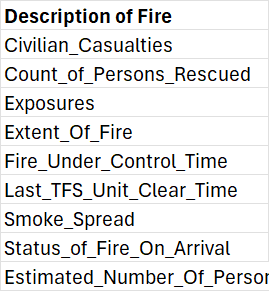

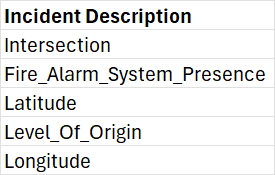

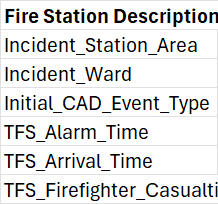

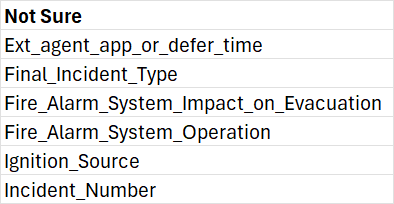

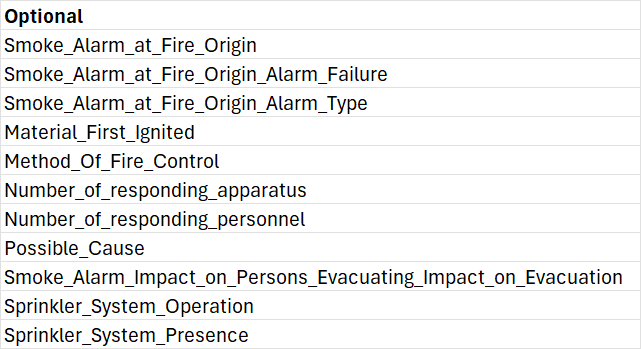

In [274]:
from IPython.display import FileLink
df.to_csv('Fire_Incidents_Data_Imputed2.csv', index=False)  # index=False to avoid saving row indices
FileLink('Fire_Incidents_Data_Imputed2.csv')

/Users/maggiehuang/Desktop/INSY662_Data_Mining_and_Visualization_for_Analytic/INSY662-Data-Mining-and-Visualization-Project/Fire_Incidents_Data_Imputed2.csv

# You can use the following code to look at the distribution of Estimated dollar Loss and explore the data of each category.

Just change the value of "cat" with the required category.

In [275]:
cat = 'Vehicle'
case1 = df[df['Incident_Category'] == cat]

In [276]:
# Check the numerical distribution of Estimated_Dollar_Loss in case1 df
case1['Estimated_Dollar_Loss'].describe()

count       4,754
mean       22,001
std        65,464
min             0
25%         3,000
50%        10,000
75%        20,000
max     3,000,000
Name: Estimated_Dollar_Loss, dtype: float64

In [277]:
case1[case1['Estimated_Dollar_Loss'].isnull()].head(10)

,_id_x,Area_of_Origin,Building_Status,Business_Impact,Civilian_Casualties,Count_of_Persons_Rescued,Estimated_Dollar_Loss,Estimated_Number_Of_Persons_Displaced,Exposures,Ext_agent_app_or_defer_time,Extent_Of_Fire,Final_Incident_Type,Fire_Alarm_System_Impact_on_Evacuation,Fire_Alarm_System_Operation,Fire_Alarm_System_Presence,Fire_Under_Control_Time,Ignition_Source,Incident_Number,Incident_Station_Area,Incident_Ward,Initial_CAD_Event_Type,Intersection,Last_TFS_Unit_Clear_Time,Latitude,Level_Of_Origin,Longitude,Material_First_Ignited,Method_Of_Fire_Control,Number_of_responding_apparatus,Number_of_responding_personnel,Possible_Cause,Property_Use,Smoke_Alarm_at_Fire_Origin,Smoke_Alarm_at_Fire_Origin_Alarm_Failure,Smoke_Alarm_at_Fire_Origin_Alarm_Type,Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation,Smoke_Spread,Sprinkler_System_Operation,Sprinkler_System_Presence,Status_of_Fire_On_Arrival,TFS_Alarm_Time,TFS_Arrival_Time,TFS_Firefighter_Casualties,Response_Time_Seconds,_id_y,ADDRESS_POINT_ID,ADDRESS_NUMBER,LINEAR_NAME_FULL,ADDRESS,MUNICIPALITY_NAME,CENTRELINE_ID,OBJECTID,ID,STATION,YEAR_BUILD,WARD,WARD_NAME,TYPE_DESC,PUBLIC_ED_OFFICE,FIRE_PREV_OFFICE,FIRE_OTHER,geometry,Combined_Address,station_longitude,station_latitude,distance_from_nearest_station,time_from_nearest_station,response_delay,Mapped_Initial_CAD_Event_Type,Incident_Category
2045,3695041,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01 - Fire,NaN,NaN,NaN,NaN,NaN,F21082537,211,25,Vehicle Fire,Bathgate Dr / Clemes Dr,2021-08-14T13:58:17,44,NaN,-79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-08-14 06:01:31,2021-08-14 06:12:01,NaN,630,1,4236992,900,Tapscott Rd,900 Tapscott Rd,Scarborough,4236991,1520443,74,211,1982,23,Scarborough North,Fire Station,NaN,NaN,NaN,"{'type': 'MultiPoint', 'coordinates': [[-79.24...","900 Tapscott Rd, Scarborough",-79,44,"14,047","1,066",-436,Vehicle Fire,Vehicle
2586,3695582,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01 - Fire,NaN,NaN,NaN,NaN,NaN,F21128405,225,20,Vehicle Fire,Danforth Rd / Pilkington Dr,2021-12-03T04:57:38,44,NaN,-79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-12-03 04:10:20,2021-12-03 04:17:04,NaN,404,43,5464019,3600,Danforth Ave,3600 Danforth Ave,Scarborough,5464008,2642292,37,225,1998,20,Scarborough Southwest,Fire Station,NaN,NaN,NaN,"{'type': 'MultiPoint', 'coordinates': [[-79.26...","3600 Danforth Ave, Scarborough",-79,44,"1,698",235,169,Vehicle Fire,Vehicle
19191,3712212,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01 - Fire,NaN,NaN,NaN,NaN,NaN,F21136753,411,7,Vehicle Fire,St Lucie Dr / Azalea Crt,2021-12-23T04:16:36,44,NaN,-80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-12-23 02:48:30,2021-12-23 02:55:27,NaN,417,65,13497504,75,Toryork Dr,75 Toryork Dr,North York,10367893,3301795,89,411,1964,7,Humber River-Black Creek,Fire Station,NaN,NaN,"Emergency Management, Health & Safety (EMH&S) ...","{'type': 'MultiPoint', 'coordinates': [[-79.54...","75 Toryork Dr, North York",-80,44,"2,377",305,112,Vehicle Fire,Vehicle
19614,3712635,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01 - Fire,NaN,NaN,NaN,NaN,NaN,F21090040,234,24,Vehicle Fire,Kingston Rd / Scarborough Golf Club Rd,2021-08-31T02:36:51,44,NaN,-79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-08-31 01:59:36,2021-08-31 02:05:37,NaN,361,19,2219446,40,Coronation Dr,40 Coronation Dr,Scarborough,2219434,2004920,70,234,1966,24,Scarborough-Guildwood,Fire Station,NaN,NaN,NaN,"{'type': 'MultiPoint', 'coordinates': [[-79.19...","40 Coronation Dr, Scarborough",-79,44,"2,654",290,71,Vehicle Fire,Vehicle
20182,3713203,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01 - Fire,NaN,NaN,NaN,NaN,NaN,F20083571,242,23,Vehicle Fire - Underground,Finch Ave E / Sandhurst Crcl,2020-08-24T03:56:50,44,NaN,-79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-08-24 02:35:02,2020-08-24 02:40:14,NaN,312,80,9487007,2733,Brimley Rd,2733 Brimley Rd,Scarborough,30108578,4308527,75,242,1975,23,Scarborough North,Fire Station,NaN,NaN,NaN,"{'type':

In [278]:
case1[case1['Estimated_Dollar_Loss']<20000].groupby(['Mapped_Initial_CAD_Event_Type'])['Estimated_Dollar_Loss'].mean()

Mapped_Initial_CAD_Event_Type
VEF                                           5,357
Vehicle - Personal Injury                     6,500
Vehicle - Personal Injury Highway             7,558
Vehicle Accident - Trapped                    6,086
Vehicle Accident - Trapped - Highway          5,500
Vehicle Accident with Fire                    8,125
Vehicle Fire                                  6,186
Vehicle Fire - Aircraft                       6,568
Vehicle Fire - At Transit                     7,000
Vehicle Fire - Highway                        6,830
Vehicle Fire - Natural Gas Vehicle            5,000
Vehicle Fire - Passenger                      2,500
Vehicle Fire - Passenger Incident High-Rise   6,706
Vehicle Fire - Threat to Health               7,083
Vehicle Fire - Under Control                  4,379
Vehicle Fire - Underground                    4,705
Name: Estimated_Dollar_Loss, dtype: float64

In [279]:
case1[case1['Estimated_Dollar_Loss']<5000].head(10)

,_id_x,Area_of_Origin,Building_Status,Business_Impact,Civilian_Casualties,Count_of_Persons_Rescued,Estimated_Dollar_Loss,Estimated_Number_Of_Persons_Displaced,Exposures,Ext_agent_app_or_defer_time,Extent_Of_Fire,Final_Incident_Type,Fire_Alarm_System_Impact_on_Evacuation,Fire_Alarm_System_Operation,Fire_Alarm_System_Presence,Fire_Under_Control_Time,Ignition_Source,Incident_Number,Incident_Station_Area,Incident_Ward,Initial_CAD_Event_Type,Intersection,Last_TFS_Unit_Clear_Time,Latitude,Level_Of_Origin,Longitude,Material_First_Ignited,Method_Of_Fire_Control,Number_of_responding_apparatus,Number_of_responding_personnel,Possible_Cause,Property_Use,Smoke_Alarm_at_Fire_Origin,Smoke_Alarm_at_Fire_Origin_Alarm_Failure,Smoke_Alarm_at_Fire_Origin_Alarm_Type,Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation,Smoke_Spread,Sprinkler_System_Operation,Sprinkler_System_Presence,Status_of_Fire_On_Arrival,TFS_Alarm_Time,TFS_Arrival_Time,TFS_Firefighter_Casualties,Response_Time_Seconds,_id_y,ADDRESS_POINT_ID,ADDRESS_NUMBER,LINEAR_NAME_FULL,ADDRESS,MUNICIPALITY_NAME,CENTRELINE_ID,OBJECTID,ID,STATION,YEAR_BUILD,WARD,WARD_NAME,TYPE_DESC,PUBLIC_ED_OFFICE,FIRE_PREV_OFFICE,FIRE_OTHER,geometry,Combined_Address,station_longitude,station_latitude,distance_from_nearest_station,time_from_nearest_station,response_delay,Mapped_Initial_CAD_Event_Type,Incident_Category
5,3693001,81 - Engine Area,NaN,NaN,0,0,"1,500",NaN,NaN,2018-02-25T18:38:00,NaN,01 - Fire,NaN,NaN,NaN,2018-02-25T18:40:00,999 - Undetermined,F18021274,215,25,Vehicle Fire,Lawrence Ave E / Beechgrove Dr,2018-02-25T19:08:28,44,NaN,-79,47 - Vehicle,1 - Extinguished by fire department,7,25,99 - Undetermined,837 - Vehicles or Vehicle Parts,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4 - Flames showing from small area (one storey...,2018-02-25 18:31:19,2018-02-25 18:35:17,0,238,95,354673,5318,Lawrence Ave E,5318 Lawrence Ave E,Scarborough,107237,4597878,69,215,1974,25,Scarborough-Rouge Park,Fire Station,NaN,NaN,NaN,"{'type': 'MultiPoint', 'coordinates': [[-79.14...","5318 Lawrence Ave E, Scarborough",-79,44,"1,265",132,106,Vehicle Fire,Vehicle
24,3693020,81 - Engine Area,NaN,NaN,0,0,100,NaN,NaN,2018-01-04T20:36:25,NaN,01 - Fire,NaN,NaN,NaN,2018-01-04T20:38:17,999 - Undetermined,F18001589,441,1,Vehicle Fire,Bethridge Rd / Precision Rd,2018-01-04T20:51:32,44,NaN,-80,72 - Diesel Fuel/Fuel Oil,1 - Extinguished by fire department,3,11,51 - Mechanical Failure,891 - Outdoor general auto parking,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9 - Unclassified,2018-01-04 20:25:55,2018-01-04 20:32:05,0,370,99,6044964,947,Martin Grove Rd,947 Martin Grove Rd,Etobicoke,6044958,4653861,6,441,1964,1,Etobicoke North,Fire Station,NaN,NaN,West Training Centre / Fire Training Tower,"{'type': 'MultiPoint', 'coordinates': [[-79.57...","947 Martin Grove Rd, Etobicoke",-80,44,"2,468",344,26,Vehicle Fire,Vehicle
39,3693035,86 - Passenger Area,NaN,NaN,0,0,"4,000",NaN,NaN,2018-01-14T13:18:30,NaN,01 - Fire,NaN,NaN,NaN,2018-01-14T13:20:00,999 - Undetermined,F18006306,312,11,Vehicle Fire,Yonge St / Collier St,2018-01-14T13:45:27,44,NaN,-79,99 - Undetermined (formerly 98),1 - Extinguished by fire department,1,4,99 - Undetermined,901 - Automobile,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4 - Flames showing from small area (one storey...,2018-01-14 13:14:07,2018-01-14 13:16:32,0,145,30,8677247,34,Yorkville Ave,34 Yorkville Ave,former Toronto,14014191,2224532,19,312,1876,11,University-Rosedale,Fire Station,NaN,NaN,NaN,"{'type': 'MultiPoint', 'coordinates': [[-79.38...","34 Yorkville Ave, former Toronto",-79,44,142,69,76,Vehicle Fire,Vehicle
67,3693063,81 - Engine Area,NaN,NaN,0,0,"3,000",NaN,NaN,2018-02-02T16:18:26,NaN,01 - Fire,NaN,NaN,NaN,2018-02-02T16:22:47,82 - Vehicle - Mechanical,F18013133,343,12,Vehicle Accident with Fire,St Clair Ave W / Tweedsmuir Ave,2018-02-02T17:04:48,44,NaN,-79,47 - Vehicle,1 - Extinguished by fire department,2,8,"60 - Other unintentional cause, not classified",901 - Automobile,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4 - Flames showing from small area (one 

In [280]:
df.describe()

,_id_x,Civilian_Casualties,Count_of_Persons_Rescued,Estimated_Dollar_Loss,Estimated_Number_Of_Persons_Displaced,Exposures,Incident_Station_Area,Incident_Ward,Latitude,Longitude,Number_of_responding_apparatus,Number_of_responding_personnel,TFS_Firefighter_Casualties,Response_Time_Seconds,_id_y,ADDRESS_POINT_ID,ADDRESS_NUMBER,CENTRELINE_ID,OBJECTID,ID,STATION,YEAR_BUILD,WARD,station_longitude,station_latitude,distance_from_nearest_station,time_from_nearest_station,response_delay
count,"24,110","20,194","23,897","23,886","16,845","4,301","24,110","23,995","24,110","24,110","23,897","23,897","23,897","24,110","24,110","24,110","24,110","24,110","24,110","24,110","24,110","24,110","24,110","24,110","24,110","24,110","24,110","24,110"
mean,"3,708,397",0,0,"38,080",16,0,284,17,44,-79,8,26,0,318,50,"7,539,168","1,078","11,149,545","3,027,171",47,284,"1,962",12,-79,44,"1,728",268,50
std,"8,697",0,1,"398,994",116,1,110,11,0,0,8,25,0,306,28,"5,722,674","1,483","9,736,511","993,933",30,110,84,7,0,0,"1,343",136,318
min,"3,692,996",0,0,0,0,0,111,0,44,-80,1,0,0,1,1,"19,832",3,"7,809","1,520,443",1,111,0,1,-80,44,0,0,"-2,473"
25%,"3,701,558",0,0,500,0,0,212,7,44,-79,3,12,0,251,29,"2,820,826",130,"2,219,434","2,175,731",22,212,"1,956",6,-79,44,928,182,-17
50%,"3,707,596",0,0,"4,000",0,0,313,15,44,-79,6,21,0,304,49,"7,583,839",441,"9,655,751","2,982,185",41,313,"1,965",11,-79,44,"1,457",255,52
75%,"3,714,967",0,0,"20,000",1,0,411,24,44,-79,10,33,0,365,74,"9,847,351","1,550","14,666,179","4,164,722",76,411,"1,980",17,-79,44,"2,166",335,117
max,"3,725,923",15,86,"50,000,000",999,7,445,44,44,-79,436,"1,275",4,"40,942",100,"30,055,401","8,500","30,131,680","4,659,390",96,445,"2,014",25,-79,44,"45,145","2,763","40,739"


# Average response time

### Checking unqiue values in each column

In [281]:
# Check unique and null values for all columns
unique_values = df.nunique()
null_values = df.isnull().sum()

# Display the results
for column in df.columns:
    print(f"Column: {column}")
    print(f"Unique values: {unique_values[column]}")
    print(f"Null values: {null_values[column]}")
    print("-" * 40)

Column: _id_x
Unique values: 24110
Null values: 0
----------------------------------------
Column: Area_of_Origin
Unique values: 74
Null values: 214
----------------------------------------
Column: Building_Status
Unique values: 7
Null values: 7262
----------------------------------------
Column: Business_Impact
Unique values: 7
Null values: 7266
----------------------------------------
Column: Civilian_Casualties
Unique values: 10
Null values: 3916
----------------------------------------
Column: Count_of_Persons_Rescued
Unique values: 23
Null values: 213
----------------------------------------
Column: Estimated_Dollar_Loss
Unique values: 265
Null values: 224
----------------------------------------
Column: Estimated_Number_Of_Persons_Displaced
Unique values: 64
Null values: 7265
----------------------------------------
Column: Exposures
Unique values: 8
Null values: 19809
----------------------------------------
Column: Ext_agent_app_or_defer_time
Unique values: 23882
Null values: 2

In [282]:
# Assuming df is your DataFrame (as defined in the previous code)
if '_id_x' in df.columns:
  df = df.drop(columns=['_id_x'])
  print("Column '_id_x' dropped successfully.")
else:
  print("Column '_id_x' not found in the DataFrame.")

Column '_id_x' dropped successfully.


### Checking for duplicates

In [283]:
# Check for duplicate rows
duplicate_rows = df[df.duplicated()]

# Display the duplicate rows
print(f"Number of duplicate rows: {duplicate_rows.shape[0]}")
duplicate_rows

Number of duplicate rows: 0


,Area_of_Origin,Building_Status,Business_Impact,Civilian_Casualties,Count_of_Persons_Rescued,Estimated_Dollar_Loss,Estimated_Number_Of_Persons_Displaced,Exposures,Ext_agent_app_or_defer_time,Extent_Of_Fire,Final_Incident_Type,Fire_Alarm_System_Impact_on_Evacuation,Fire_Alarm_System_Operation,Fire_Alarm_System_Presence,Fire_Under_Control_Time,Ignition_Source,Incident_Number,Incident_Station_Area,Incident_Ward,Initial_CAD_Event_Type,Intersection,Last_TFS_Unit_Clear_Time,Latitude,Level_Of_Origin,Longitude,Material_First_Ignited,Method_Of_Fire_Control,Number_of_responding_apparatus,Number_of_responding_personnel,Possible_Cause,Property_Use,Smoke_Alarm_at_Fire_Origin,Smoke_Alarm_at_Fire_Origin_Alarm_Failure,Smoke_Alarm_at_Fire_Origin_Alarm_Type,Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation,Smoke_Spread,Sprinkler_System_Operation,Sprinkler_System_Presence,Status_of_Fire_On_Arrival,TFS_Alarm_Time,TFS_Arrival_Time,TFS_Firefighter_Casualties,Response_Time_Seconds,_id_y,ADDRESS_POINT_ID,ADDRESS_NUMBER,LINEAR_NAME_FULL,ADDRESS,MUNICIPALITY_NAME,CENTRELINE_ID,OBJECTID,ID,STATION,YEAR_BUILD,WARD,WARD_NAME,TYPE_DESC,PUBLIC_ED_OFFICE,FIRE_PREV_OFFICE,FIRE_OTHER,geometry,Combined_Address,station_longitude,station_latitude,distance_from_nearest_station,time_from_nearest_station,response_delay,Mapped_Initial_CAD_Event_Type,Incident_Category


In [284]:
# Split the 'Area_of_Origin' column based on '-' and extract the part after '-'
df['Area_of_Origin'] = df['Area_of_Origin'].str.split('-').str[1].str.strip()

In [285]:
# Get the unique values of the 'Area_of_Origin' column
area_of_origin_values = df['Area_of_Origin'].unique()

# Check value counts for each unique value and order in descending order
value_counts = df['Area_of_Origin'].value_counts().sort_values(ascending=False)
value_counts

Area_of_Origin
Cooking Area or Kitchen                                             4070
Engine Area                                                         2990
Trash, Rubbish Storage (inc garbage chute room, garbage/industri    1599
Porch or Balcony                                                    1516
Sleeping Area or Bedroom (inc. patients room, dormitory, etc)       1313
                                                                    ... 
Operating Room, Treatment or Examination Area                         10
Incinerator Room                                                       4
Fuel Dispensing Area (outside)                                         3
Records storage area (inc vaults)                                      2
Backstage, dressing room                                               1
Name: count, Length: 73, dtype: int64

## Note the highest percentage of cases of fire

In [286]:
# Calculate the percentage of each unique value in the 'Area_of_Origin' column
percentages = df['Area_of_Origin'].value_counts(normalize=True) * 100

# Display the percentages
percentages.head(10)  # Display the top 10 percentages

Area_of_Origin
Cooking Area or Kitchen                                            17
Engine Area                                                        13
Trash, Rubbish Storage (inc garbage chute room, garbage/industri    7
Porch or Balcony                                                    6
Sleeping Area or Bedroom (inc. patients room, dormitory, etc)       5
Living Area (e.g. living, TV, recreation, etc)                      4
Trash, rubbish area (outside)                                       3
Undetermined  (formerly 98)                                         3
Other                                                               3
Garage                                                              3
Name: proportion, dtype: float64

#### Checking the type of building where the fire occurred

In [287]:
building_status_counts = df['Building_Status'].value_counts()
building_status_counts

Building_Status
01 - Normal (no change)               14650
08 - Not Applicable                     977
02 - Under Renovation                   704
03 - Under Construction                 231
09 - Undetermined                       139
05 - Abandoned, vacant (long term)      127
04 - Under Demolition                    20
Name: count, dtype: int64

In [288]:
# prompt: check the null and non null in Building_Status column

# Check for null values in 'Building_Status'
null_building_status = df['Building_Status'].isnull().sum()
print(f"Number of null values in 'Building_Status': {null_building_status}")

# Check for non-null values in 'Building_Status'
non_null_building_status = df['Building_Status'].notnull().sum()
print(f"Number of non-null values in 'Building_Status': {non_null_building_status}")

Number of null values in 'Building_Status': 7262
Number of non-null values in 'Building_Status': 16848


In [289]:
# prompt: check distinct values of area of origin where Building_Status is null vs non-null and check the common items between the two and which exists only in each of them

# Assuming df is your DataFrame (as defined in the previous code)

# Get distinct 'Area_of_Origin' values where 'Building_Status' is null
null_building_status_areas = df[df['Building_Status'].isnull()]['Area_of_Origin'].unique()

# Get distinct 'Area_of_Origin' values where 'Building_Status' is not null
non_null_building_status_areas = df[df['Building_Status'].notnull()]['Area_of_Origin'].unique()

# Find common areas
common_areas = set(null_building_status_areas) & set(non_null_building_status_areas)
print("Common Areas of Origin:", common_areas)

# Find areas only in null 'Building_Status'
null_only_areas = set(null_building_status_areas) - set(non_null_building_status_areas)
print("\nAreas of Origin only in null 'Building_Status':", null_only_areas)

# Find areas only in non-null 'Building_Status'
non_null_only_areas = set(non_null_building_status_areas) - set(null_building_status_areas)
print("\nAreas of Origin only in non-null 'Building_Status':", non_null_only_areas)

Common Areas of Origin: {'Awning or Canopy', 'Open Area (inc lawn, field, farmyard, park, playing field, pier,', 'Garage', 'Other Storage Area', 'Process Manufacturing (inc manf, prod assembly, repair)', 'Other Functional Area', 'Exterior Wall', 'Covered Court, Atrium, mall concourse', 'Other Means of Egress', 'Product Storage (inc products or materials awaiting manuf, assembly)', 'Fuel Dispensing Area (outside)', 'Attached Deck', 'Other Building Services/Support Facilities', 'Hallway, Corridor', 'Chimney/Flue Pipe', 'Other Outside Area', 'Trunk/Cargo Area', 'Sleeping Area or Bedroom (inc. patients room, dormitory, etc)', 'Trash, Rubbish Storage (inc garbage chute room, garbage/industri', 'Laundry Area', 'Laboratory', 'Under Investigation', 'Roof', 'Court, Patio, Terrace', 'Storage Area (outside)', 'Other Structural Area', 'Concealed Ceiling Area', 'Electronic Equipment', 'Living Area (e.g. living, TV, recreation, etc)', 'Running Gear (inc wheels and braking systems, transmission syste

### If the building is not Normal, then how does fire incident occurs? (It couldn't be due to kitchen, right?)

In [290]:
# Filter the DataFrame for rows where Building_Status is not '01 - Normal (no change)'
filtered_df = df[df['Building_Status'] != '01 - Normal (no change)']

# Get the value counts for the 'Area_of_Origin' column in the filtered DataFrame
filtered_area_of_origin_counts = filtered_df['Area_of_Origin'].value_counts()

# Display the results
filtered_area_of_origin_counts.head(10)


Area_of_Origin
Engine Area                                                         2863
Trash, Rubbish Storage (inc garbage chute room, garbage/industri     626
Undetermined  (formerly 98)                                          555
Trash, rubbish area (outside)                                        509
Electrical Systems                                                   436
Other                                                                427
Passenger Area                                                       410
Other Vehicle Area                                                   365
Other Outside Area                                                   340
Open Area (inc lawn, field, farmyard, park, playing field, pier,     325
Name: count, dtype: int64

### This will help us to know the extent of damage that happened due to fire incident at a business site

In [291]:
# Get the value counts for the 'Business_Impact' column
business_impact_counts = df['Business_Impact'].value_counts()

# Display the results
business_impact_counts

Business_Impact
8 - Not applicable (not a business)         7609
1 - No business interruption                6846
9 - Undetermined                            1163
2 - May resume operations within a week      891
3 - May resume operations within a month     197
5 - May not resume operations                 87
4 - May resume operations within a year       51
Name: count, dtype: int64

In [292]:
# Check for null values in 'Business_Impact'
null_business_impact = df['Business_Impact'].isnull().sum()
print(f"Number of null values in 'Business_Impact': {null_business_impact}")

# Check for non-null values in 'Business_Impact'
non_null_business_impact = df['Business_Impact'].notnull().sum()
print(f"Number of non-null values in 'Business_Impact': {non_null_business_impact}")

# Calculate and display the distribution
total_business_impact = null_business_impact + non_null_business_impact
null_percentage = (null_business_impact / total_business_impact) * 100
non_null_percentage = (non_null_business_impact / total_business_impact) * 100

Number of null values in 'Business_Impact': 7266
Number of non-null values in 'Business_Impact': 16844


In [293]:
# Create a contingency table to analyze the null distribution
contingency_table = pd.crosstab(df['Building_Status'].isnull(), df['Business_Impact'].isnull())

# Display the contingency table
contingency_table

Business_Impact,False,True
Building_Status,,
False,16844,4
True,0,7262


In [294]:
# prompt: for all cases where Business_Impact is not null, what are the different unique values of Area_of_Origin for each non-null value of Business_Impact

# Filter out rows where 'Business_Impact' is not null
business_impact_not_null = df[df['Business_Impact'].notnull()]

# Group by 'Business_Impact' and get unique 'Area_of_Origin' values for each group
area_of_origin_by_impact = business_impact_not_null.groupby('Business_Impact')['Area_of_Origin'].unique()

# Print the results
area_of_origin_by_impact = pd.DataFrame(area_of_origin_by_impact)

In [295]:
area_of_origin_by_impact

,Area_of_Origin
Business_Impact,
1 - No business interruption,"[Trash, rubbish area (outside), Sleeping Area ..."
2 - May resume operations within a week,"[Mechanical/Electrical Services Room, Cooking ..."
3 - May resume operations within a month,"[Mechanical/Electrical Services Room, Supply S..."
4 - May resume operations within a year,"[Concealed Ceiling Area, Other Outside Area, R..."
5 - May not resume operations,"[Residential/Business: Restaurant area, Mechan..."
8 - Not applicable (not a business),"[Cooking Area or Kitchen, Washroom or Bathroom..."
9 - Undetermined,"[Basement/cellar (not partitioned), Hallway, C..."


In [296]:
set1 = set(area_of_origin_by_impact['Area_of_Origin'][0])
set2 = set(area_of_origin_by_impact['Area_of_Origin'][1])
set3 = set(area_of_origin_by_impact['Area_of_Origin'][2])
set4 = set(area_of_origin_by_impact['Area_of_Origin'][3])
set5 = set(area_of_origin_by_impact['Area_of_Origin'][4])
set6 = set(area_of_origin_by_impact['Area_of_Origin'][5])
set7 = set(area_of_origin_by_impact['Area_of_Origin'][6])

In [297]:
set1.difference(set2).difference(set3).difference(set4).difference(set5).difference(set6).difference(set7)

set()

In [298]:
set2.difference(set1).difference(set3).difference(set4).difference(set5).difference(set6).difference(set7)

set()

In [299]:
set3.difference(set2).difference(set1).difference(set4).difference(set5).difference(set6).difference(set7)

{'Backstage, dressing room'}

In [300]:
set4.difference(set2).difference(set3).difference(set1).difference(set5).difference(set6).difference(set7)

set()

In [301]:
set5.difference(set2).difference(set3).difference(set4).difference(set1).difference(set6).difference(set7)

set()

In [302]:
set6.difference(set2).difference(set3).difference(set4).difference(set1).difference(set1).difference(set7)

set()

In [303]:
set7.difference(set2).difference(set3).difference(set4).difference(set1).difference(set6).difference(set1)

{'Fuel Dispensing Area (outside)'}

In [304]:
# Get the value counts for the 'Business_Impact' column
business_impact_counts = df['Business_Impact'].value_counts(normalize=True)*100

# Display the results
business_impact_counts

Business_Impact
8 - Not applicable (not a business)        45
1 - No business interruption               41
9 - Undetermined                            7
2 - May resume operations within a week     5
3 - May resume operations within a month    1
5 - May not resume operations               1
4 - May resume operations within a year     0
Name: proportion, dtype: float64

In [305]:
# Check unique values of Civilian_Casualties
unique_civilian_casualties = df['Civilian_Casualties'].unique()
print(f"Unique values of Civilian Casualties: {unique_civilian_casualties}")

# Perform descriptive analysis on Civilian_Casualties
descriptive_analysis = df['Civilian_Casualties'].value_counts()
print("\nDescriptive Analysis of Civilian Casualties:")
descriptive_analysis

Unique values of Civilian Casualties: [ 0.  1.  2.  4. nan  3.  8.  5. 15.  6.  7.]

Descriptive Analysis of Civilian Casualties:


Civilian_Casualties
0     18822
1      1117
2       161
3        54
4        28
5         4
6         4
8         2
15        1
7         1
Name: count, dtype: int64

In [306]:
# Check for null values in 'Civilian_Casualties'
null_civilian_casualties = df['Civilian_Casualties'].isnull().sum()
print(f"Number of null values in 'Civilian_Casualties': {null_civilian_casualties}")

Number of null values in 'Civilian_Casualties': 3916


In [307]:
# Check the total number of deaths
total_deaths = df['Civilian_Casualties'].sum()
print(f"Total number of deaths till date: {total_deaths}")

# Find the worst case where the maximum number of people died
worst_case = df[df['Civilian_Casualties'] == df['Civilian_Casualties'].max()]
print("\nWorst case where maximum number of people died:")
worst_case

Total number of deaths till date: 1795.0

Worst case where maximum number of people died:


,Area_of_Origin,Building_Status,Business_Impact,Civilian_Casualties,Count_of_Persons_Rescued,Estimated_Dollar_Loss,Estimated_Number_Of_Persons_Displaced,Exposures,Ext_agent_app_or_defer_time,Extent_Of_Fire,Final_Incident_Type,Fire_Alarm_System_Impact_on_Evacuation,Fire_Alarm_System_Operation,Fire_Alarm_System_Presence,Fire_Under_Control_Time,Ignition_Source,Incident_Number,Incident_Station_Area,Incident_Ward,Initial_CAD_Event_Type,Intersection,Last_TFS_Unit_Clear_Time,Latitude,Level_Of_Origin,Longitude,Material_First_Ignited,Method_Of_Fire_Control,Number_of_responding_apparatus,Number_of_responding_personnel,Possible_Cause,Property_Use,Smoke_Alarm_at_Fire_Origin,Smoke_Alarm_at_Fire_Origin_Alarm_Failure,Smoke_Alarm_at_Fire_Origin_Alarm_Type,Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation,Smoke_Spread,Sprinkler_System_Operation,Sprinkler_System_Presence,Status_of_Fire_On_Arrival,TFS_Alarm_Time,TFS_Arrival_Time,TFS_Firefighter_Casualties,Response_Time_Seconds,_id_y,ADDRESS_POINT_ID,ADDRESS_NUMBER,LINEAR_NAME_FULL,ADDRESS,MUNICIPALITY_NAME,CENTRELINE_ID,OBJECTID,ID,STATION,YEAR_BUILD,WARD,WARD_NAME,TYPE_DESC,PUBLIC_ED_OFFICE,FIRE_PREV_OFFICE,FIRE_OTHER,geometry,Combined_Address,station_longitude,station_latitude,distance_from_nearest_station,time_from_nearest_station,response_delay,Mapped_Initial_CAD_Event_Type,Incident_Category
14464,"Hallway, Corridor",01 - Normal (no change),1 - No business interruption,15,6,"1,000,000",50,NaN,2016-02-05T15:30:00,"4 - Spread beyond room of origin, same floor",01 - Fire,1 - All persons (at risk of injury) evacuated ...,1 - Fire alarm system operated,1 - Fire alarm system present,2016-02-05T15:45:00,999 - Undetermined,F16011041,213,42,FAR,Neilson Rd / Sewell's Rd / Tapscott Rd,2016-02-06T08:58:09,44,005,-79,"21 - Upholstered Sofa, Chair, etc.",1 - Extinguished by fire department,39,117,99 - Undetermined,323 - Multi-Unit Dwelling - Over 12 Units,2 - Floor/suite of fire origin: Smoke alarm pr...,98 - Not applicable: Alarm operated OR presenc...,4 - Interconnected,2 - Some persons (at risk) self evacuated as a...,"7 - Spread to other floors, confined to building",8 - Not applicable - no sprinkler system present,3 - No sprinkler system,3 - Fire with smoke showing only - including v...,2016-02-05 15:03:38,2016-02-05 15:08:01,0,263,37,11533910,7,Lapsley Rd,7 Lapsley Rd,Scarborough,11533909,2458686,72,213,1974,23,Scarborough North,Fire Station,NaN,NaN,NaN,"{'type': 'MultiPoint', 'coordinates': [[-79.22...","7 Lapsley Rd, Scarborough",-79,44,"2,029",256,7,Fire Alarm Residential,Other


## Created New Coulmns to get the Hour, Month and Day of the Week of the fire incident alarm time


In [308]:
df['TFS_Alarm_Time'] = pd.to_datetime(df['TFS_Alarm_Time'])
time=df['TFS_Alarm_Time'].iloc[0]
df['Year'] = df['TFS_Alarm_Time'].apply(lambda time:time.year)
df['Hour']=df['TFS_Alarm_Time'].apply(lambda time:time.hour)
df['Month']=df['TFS_Alarm_Time'].apply(lambda time:time.month)
df['Day of Week']=df['TFS_Alarm_Time'].apply(lambda time:time.dayofweek)
dmap={0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'}
df['Day of Week']= df['Day of Week'].map(dmap)

Top months with fire incidents

In [309]:
months = df.groupby(by=['Month']).count()['station_latitude'].sort_values(ascending=False)
months.head(12)

Month
5     2342
7     2231
6     2222
4     2079
3     2055
8     1954
12    1928
1     1924
11    1897
9     1889
10    1856
2     1733
Name: station_latitude, dtype: int64

Fire incidents peaks in May, June, & July.

In [310]:
%matplotlib inline

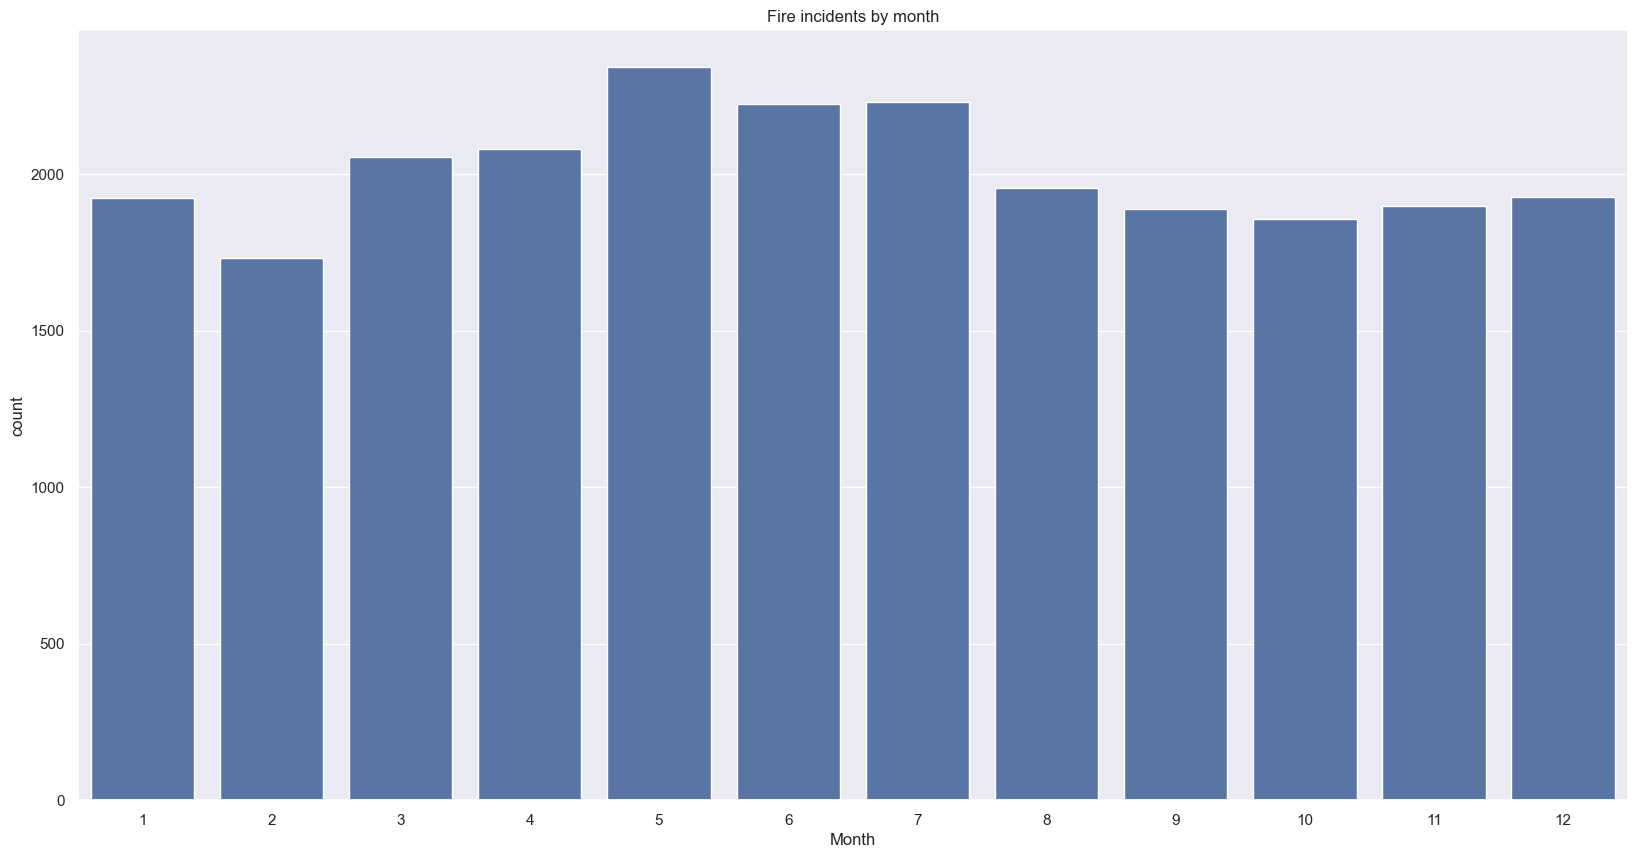

In [311]:
import matplotlib.pyplot as plt

# Set figure size
sns.set(rc={'figure.figsize':(20,10)})

# Create count plot
sns.countplot(x='Month', data=df)
plt.title("Fire incidents by month")
# Show plot (important for non-interactive environments)
plt.show()


In [312]:
sns.set(rc={'figure.figsize':(20,10)})
sns.countplot(x='Incident_Station_Area',data=df[['Month','Incident_Station_Area']])
plt.title('Average Response Time by Incident Station Area')

Text(0.5, 1.0, 'Average Response Time by Incident Station Area')

In [313]:
sns.set(rc={'figure.figsize':(20,10)})
sns.countplot(x='Day of Week',data=df,palette='inferno')
plt.title("Fire incidents by days of the week")

Text(0.5, 1.0, 'Fire incidents by days of the week')

Number of incidents has nearly doubled after 2017.

In [314]:
sns.set(rc={'figure.figsize':(20,10)})
sns.countplot(x='Year',data=df,palette='inferno')

<Axes: title={'center': 'Fire incidents by days of the week'}, xlabel='Incident_Station_Area', ylabel='count'>

Fire incident counts by day of the week and hour

In [315]:
dayHour = df.groupby(by=['Day of Week','Hour']).count()['Incident_Station_Area'].unstack()
dayHour.head()

Hour,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
Day of Week,,,,,,,,,,,,,,,,,,,,,,,,
Fri,114,112,120,107,87,80,89,88,84,134,132,162,174,180,207,207,219,216,197,216,209,192,186,119
Mon,100,116,114,75,76,84,87,112,139,110,154,136,151,155,169,188,190,179,210,195,187,162,154,151
Sat,140,127,112,100,107,95,82,85,90,113,131,144,150,186,192,198,190,195,217,228,166,178,168,156
Sun,127,136,121,110,99,83,87,81,83,103,126,153,150,203,165,181,212,214,212,188,187,194,161,146
Thu,117,100,94,94,84,79,82,92,94,123,139,155,169,192,175,192,169,198,211,202,182,180,118,118


In [316]:
sns.heatmap(dayHour, cmap='inferno')
plt.title("Fire incidents by days and hours")

Text(0.5, 1.0, 'Fire incidents by days and hours')

## Calculate Response Time

In [317]:
#convert tfs-arrival-time to date time to calculate resoponse time
df['TFS_Arrival_Time'] = pd.to_datetime(df['TFS_Arrival_Time'])
df['Response_Time']=df['TFS_Arrival_Time'] - df['TFS_Alarm_Time']

#convert time to Minute and Seconds
df['Response_Time'] = df['Response_Time'].dt.total_seconds() / 60


In [318]:
average_response_time = df.groupby('Incident_Station_Area')['Response_Time'].mean()
slowest_10_stations = average_response_time.sort_values(ascending=False).head(10).round(3)
slowest_10_stations

Incident_Station_Area
335   10
326    9
212    7
211    7
116    6
245    6
125    6
213    6
444    6
214    6
Name: Response_Time, dtype: float64

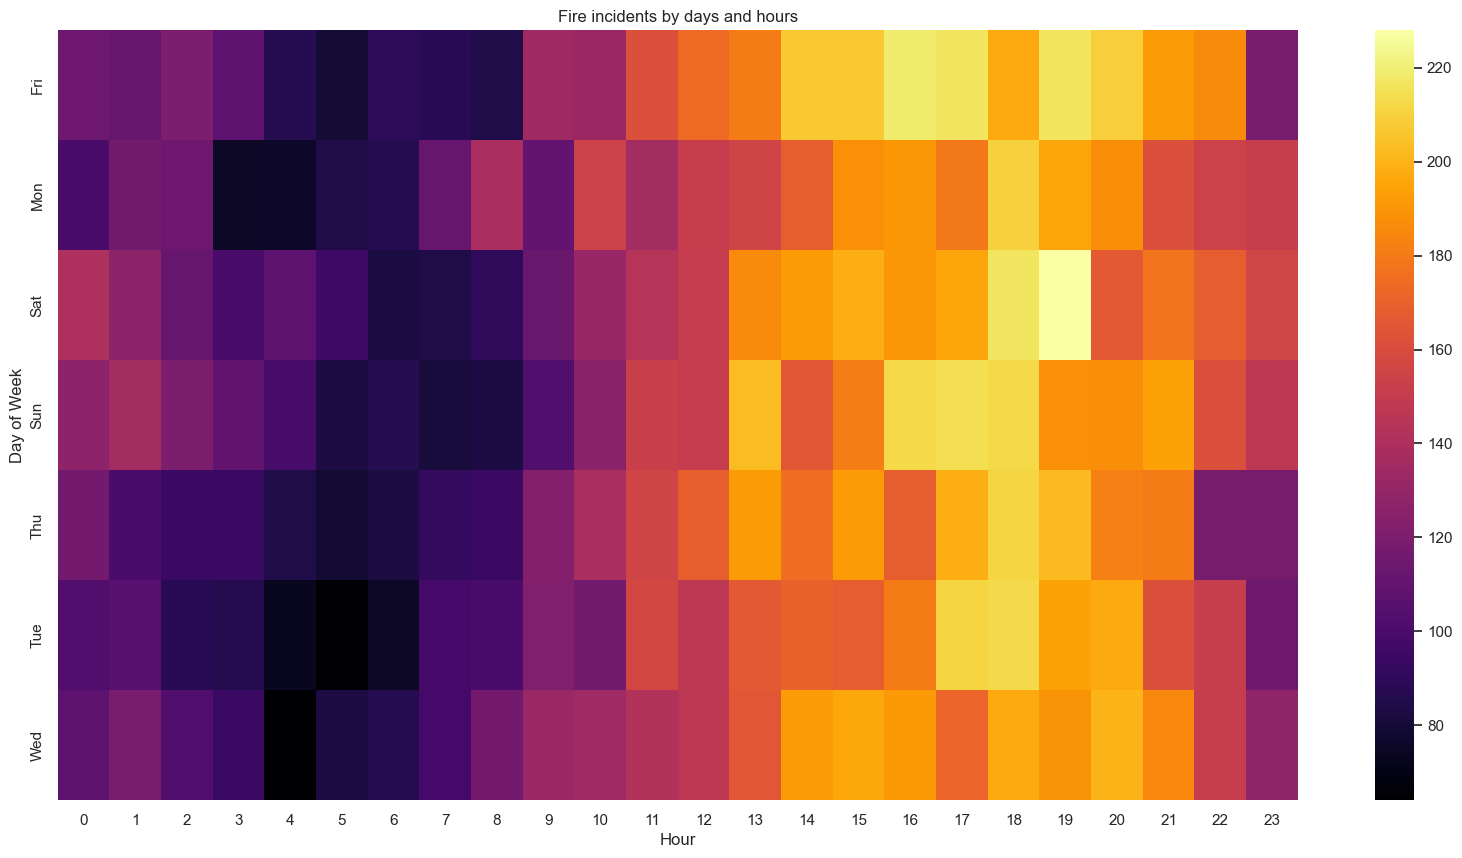

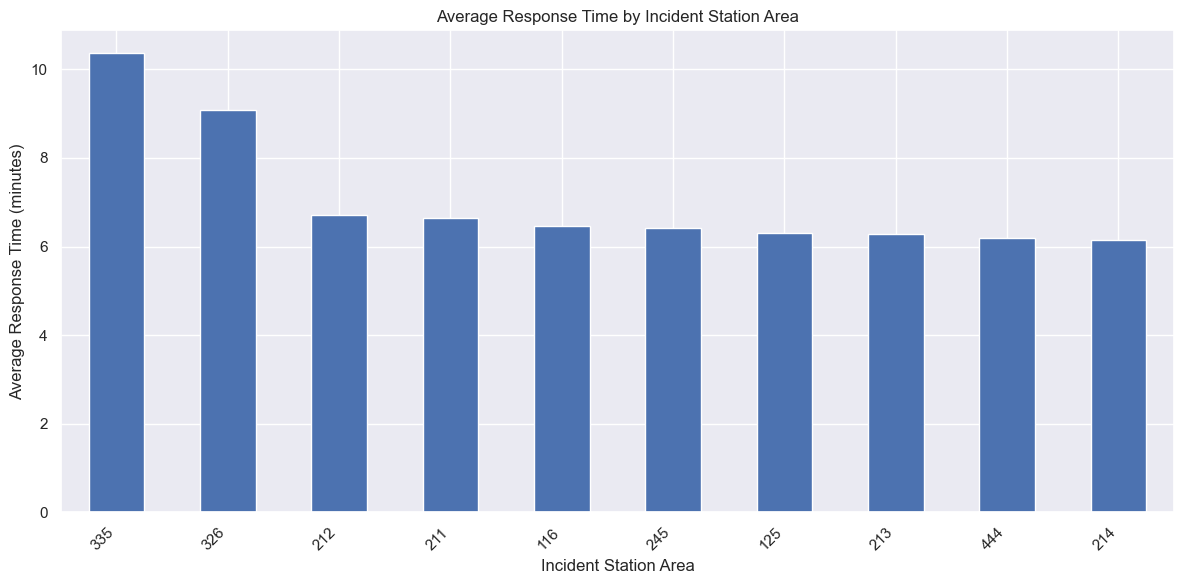

In [319]:
plt.figure(figsize=(12, 6))
slowest_10_stations.sort_values(ascending=False).plot(kind='bar')
plt.xlabel('Incident Station Area')
plt.ylabel('Average Response Time (minutes)')
plt.title('Average Response Time by Incident Station Area')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


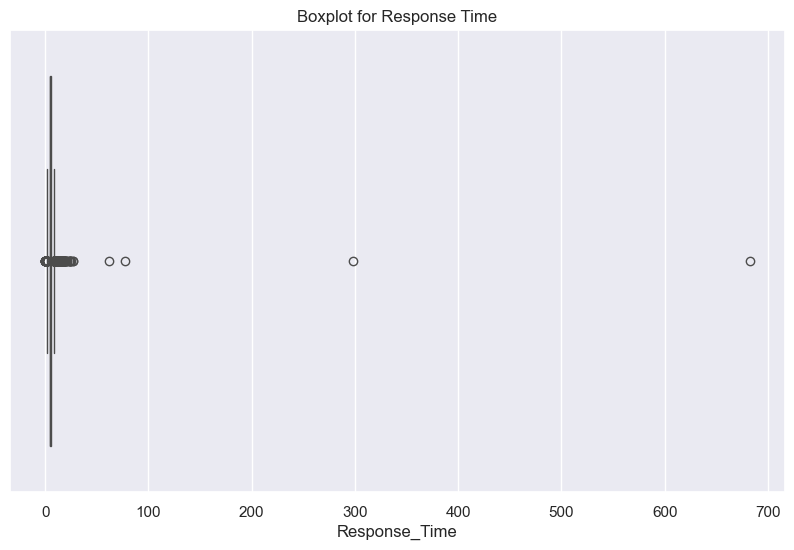

In [320]:
# Plot a boxplot for Response_Time to check for outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['Response_Time'])
plt.title('Boxplot for Response Time')
plt.show()

## Top 10 Stations with most incidents

In [321]:
incident_by_station = df['Incident_Station_Area'].value_counts()
top_10_busiest_stations = incident_by_station.sort_values(ascending=False).head(10)
top_10_busiest_stations

Incident_Station_Area
426    712
325    608
142    590
411    540
313    530
146    510
332    510
442    482
314    480
141    477
Name: count, dtype: int64

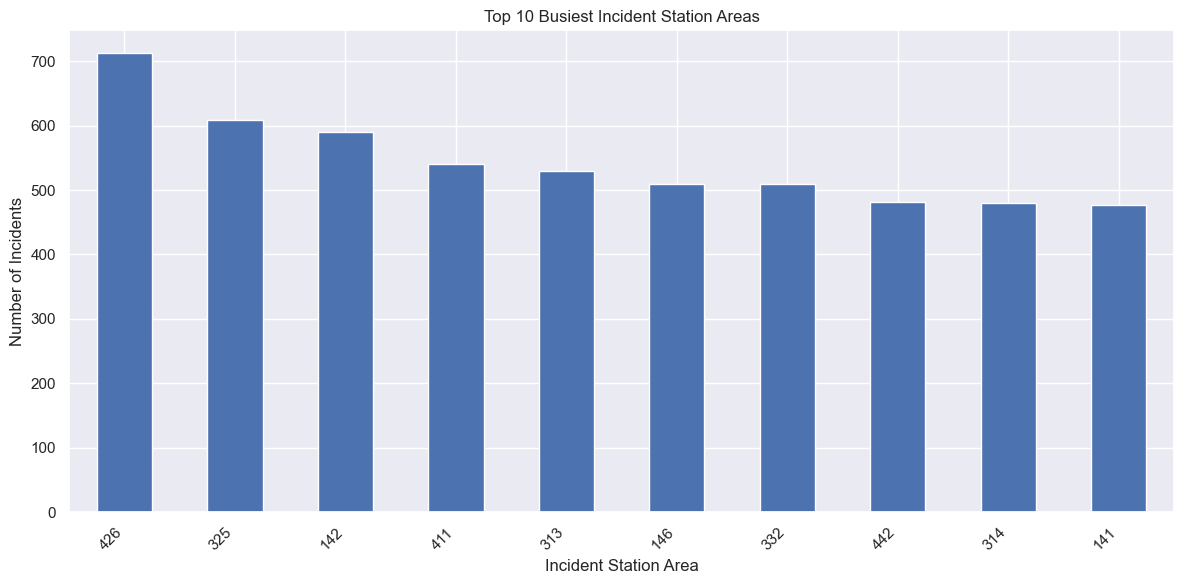

In [322]:
# plot the top 10 busiest stations

plt.figure(figsize=(12, 6))
top_10_busiest_stations.plot(kind='bar')
plt.xlabel('Incident Station Area')
plt.ylabel('Number of Incidents')
plt.title('Top 10 Busiest Incident Station Areas')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [323]:
# Assuming 'df' is your DataFrame from the previous code.
null_property_use = df['Property_Use'].isnull().sum()
print(f"Number of null values in 'Property_Use': {null_property_use}")

Number of null values in 'Property_Use': 215


In [324]:
property_count = df['Property_Use'].value_counts()
top_10_property_use = property_count.sort_values(ascending=False)#.head(10)
top_10_property_use.head(10)

Property_Use
323 - Multi-Unit Dwelling - Over 12 Units                                        4782
301 - Detached Dwelling                                                          3469
901 - Automobile                                                                 2142
302 - Semi-Detached Dwelling                                                     1052
896 - Sidewalk, street, roadway, highway, hwy (do not use for fire incidents)     995
323 - Multi-Unit Dwelling Over 12 Units                                           939
848 - Trash/Rubbish/Garbage Container or Dumpster                                 782
303 - Attached Dwelling (eg. rowhouse, townhouse, etc.)                           746
902 - Small Truck (eg. pick-up, van, etc.)                                        528
321 - Multi-Unit Dwelling - 2 to 6 Units                                          338
Name: count, dtype: int64

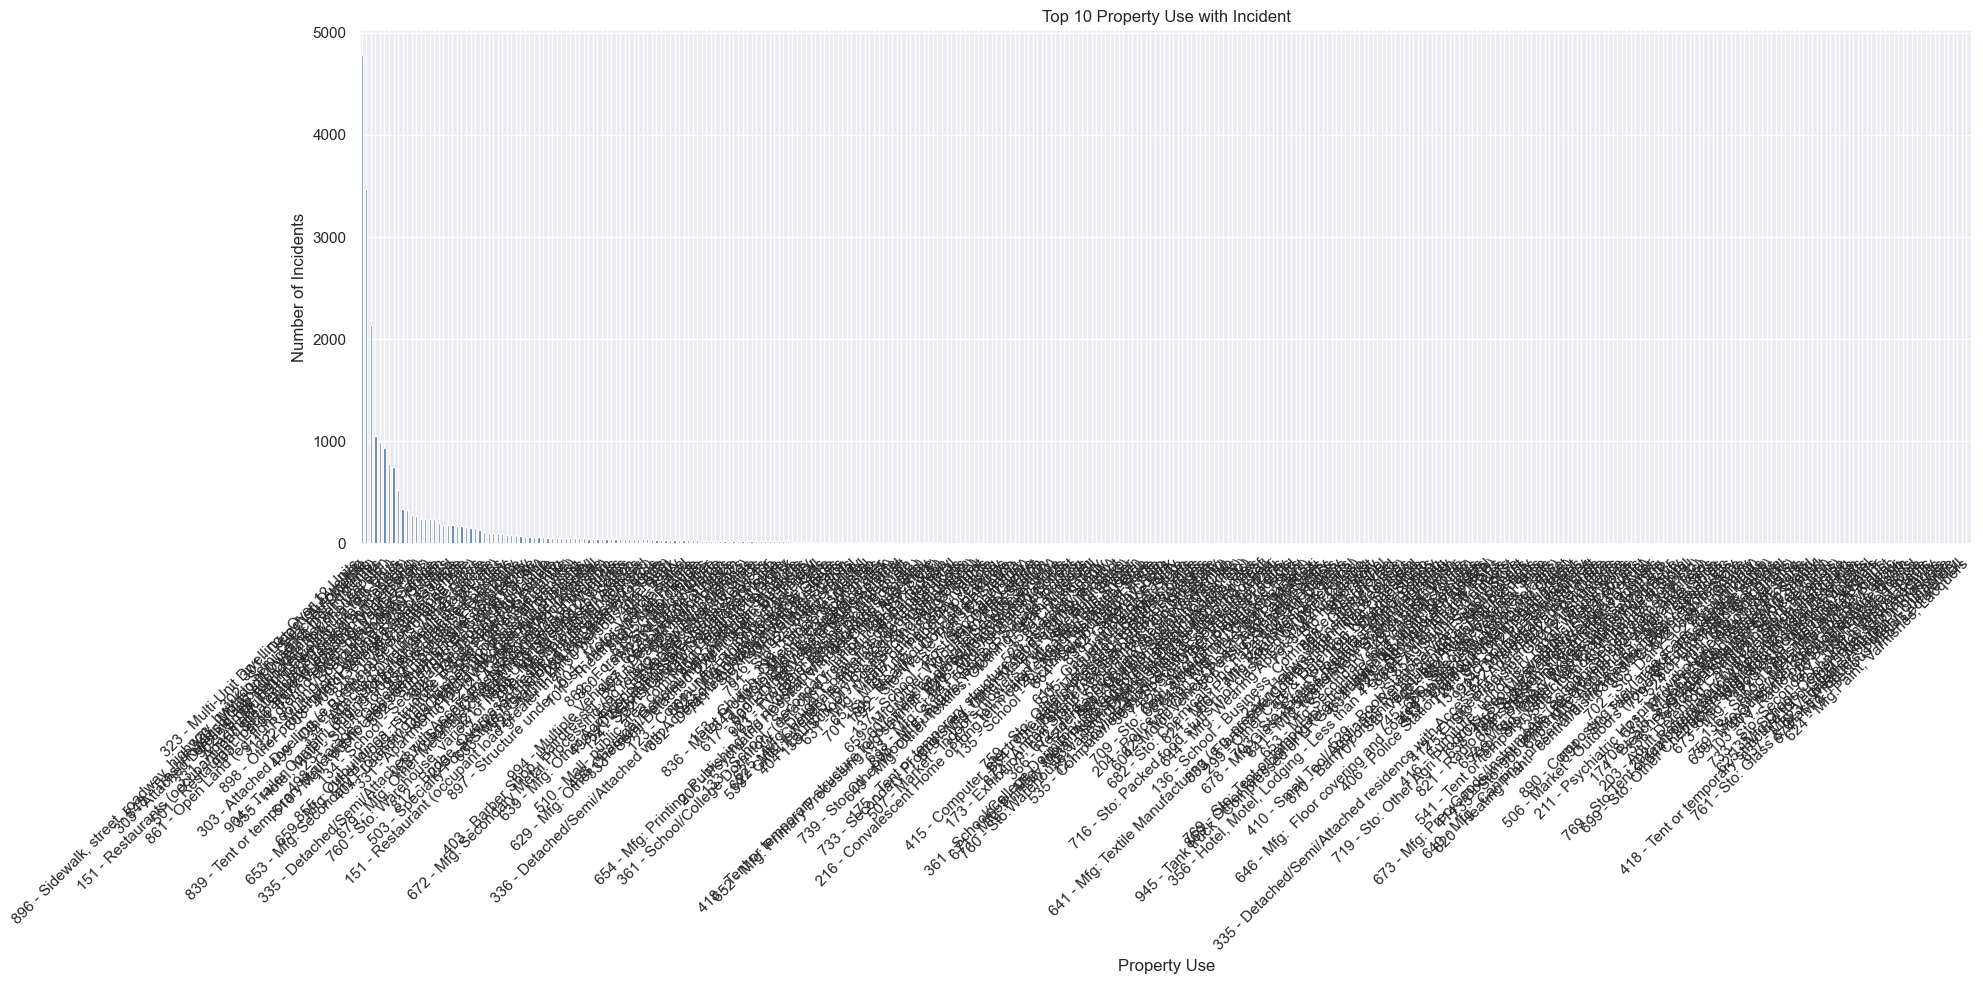

In [325]:
# plot the top 10 property use

plt.figure(figsize=(20, 10))
top_10_property_use.plot(kind='bar')
plt.xlabel('Property Use')
plt.ylabel('Number of Incidents')
plt.title('Top 10 Property Use with Incident')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


## Value Loss by Station Area

In [326]:
# Calculate the average estimated value loss by incident station
average_value_loss_by_station = df.groupby('Incident_Station_Area')['Estimated_Dollar_Loss'].mean()

top_10_loss_stations = average_value_loss_by_station.sort_values(ascending=False).head(10)
top_10_loss_stations


Incident_Station_Area
122   235,119
421   167,847
144   134,602
232    76,695
311    75,871
441    72,012
431    62,087
111    59,653
423    54,443
326    52,526
Name: Estimated_Dollar_Loss, dtype: float64

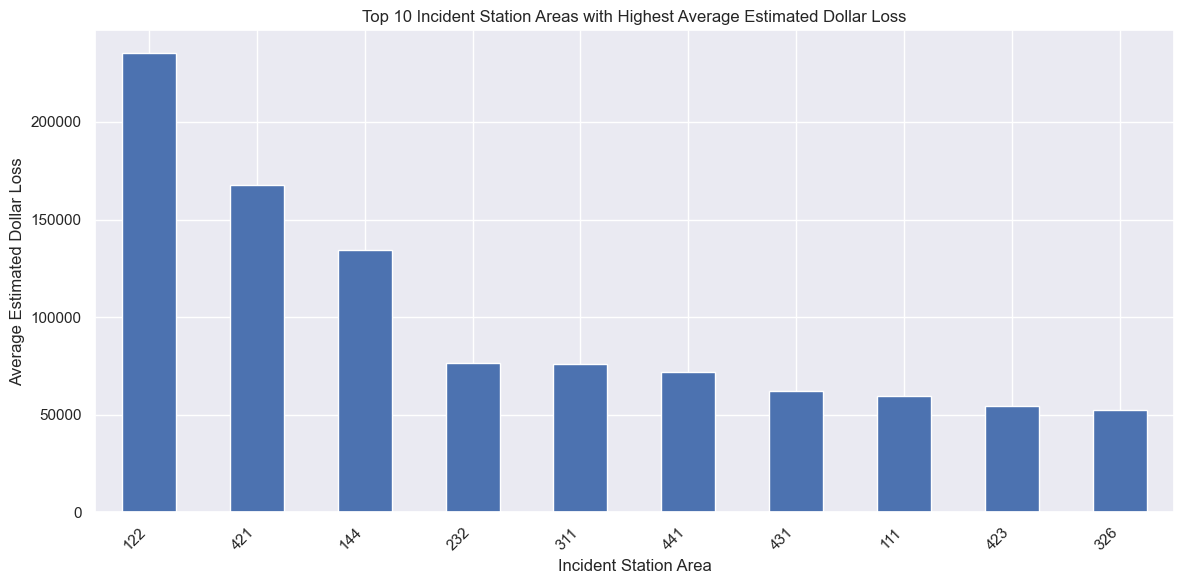

In [327]:
# plot top 10 stations with highest loss

plt.figure(figsize=(12, 6))
top_10_loss_stations.plot(kind='bar')
plt.xlabel('Incident Station Area')
plt.ylabel('Average Estimated Dollar Loss')
plt.title('Top 10 Incident Station Areas with Highest Average Estimated Dollar Loss')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [328]:

# Calculate the average civilian casualties by incident station area
average_casualties_by_station = df.groupby('Incident_Station_Area')['Civilian_Casualties'].mean()

top_10_casualty_stations = average_casualties_by_station.sort_values(ascending=False).head(10)

top_10_casualty_stations




Incident_Station_Area
144   3
215   0
234   0
421   0
322   0
434   0
422   0
442   0
323   0
423   0
Name: Civilian_Casualties, dtype: float64

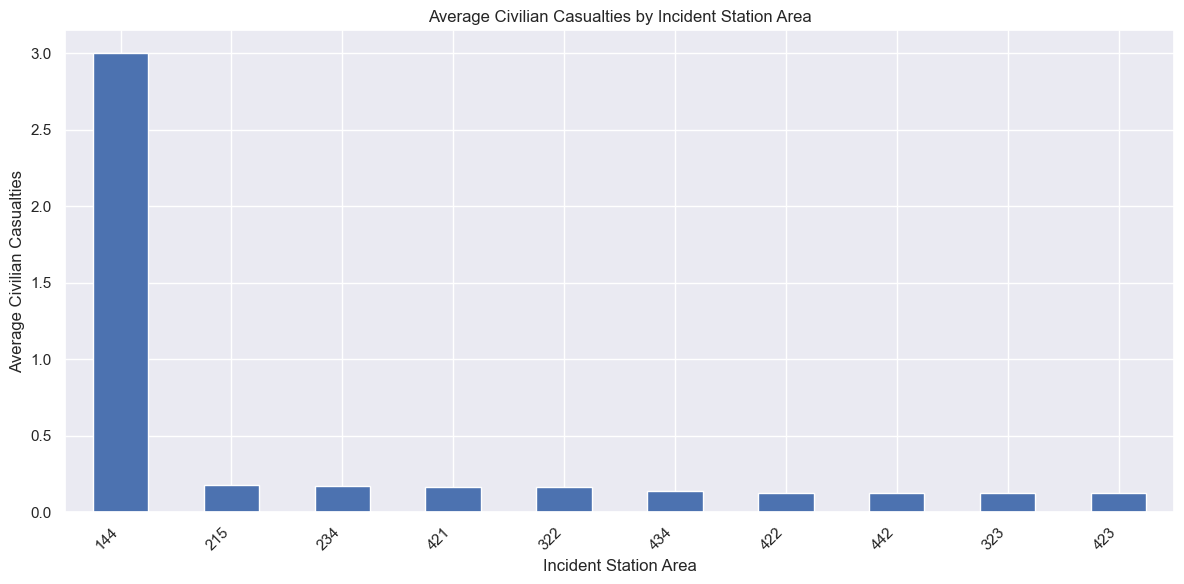

In [329]:
# Plot the average casualties by station area
plt.figure(figsize=(12, 6))
top_10_casualty_stations.sort_values(ascending=False).plot(kind='bar')
plt.xlabel('Incident Station Area')
plt.ylabel('Average Civilian Casualties')
plt.title('Average Civilian Casualties by Incident Station Area')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [330]:
file_path = "/Users/atharvavyas/Desktop/McGill Academics/AU24/INSY 662/Projectmissing_values_table.csv"
table1.to_csv(file_path, index=False)

NameError: name 'table1' is not defined

In [ ]:
# Drop Final_Incident_Type == 03 - NO LOSS OUTDOOR fire (exc: Sus.arson,vandal,child playing,recycling or dump fires)
df = pd.read_csv('/Users/atharvavyas/Desktop/McGill Academics/AU24/INSY 662/Project/Fire Incidents Data.csv')
# Assuming `df` is your DataFrame
df = df[df['Final_Incident_Type'] != '03 - NO LOSS OUTDOOR fire (exc: Sus.arson,vandal,child playing,recycling or dump fires)']



/var/folders/vv/lxk5p8wx097gv6r501nn13tw0000gn/T/ipykernel_97426/2599387803.py:2: DtypeWarning: Columns (1,2,3,9,10,12,13,14,15,16,18,24,26,27,30,32,33,34,35,36,37,38,39) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/atharvavyas/Desktop/McGill Academics/AU24/INSY 662/Project/Fire Incidents Data.csv')


In [ ]:
# Identify fires by station

print(df['Final_Incident_Type'].unique())

# Ext_agent_app_or_defer_time can be used to identify how long fire took to subside with "fire_under_control". We can understand how the extent of financial damage is related to this.
# We can also use the time at which the last fire guy
#

['01 - Fire'
 '02 - Explosion (including during Fire, excluding Codes 3 & 11-13)']


In [ ]:
# Display basic info about dataset
print("Dataset Info:")
print(df.info())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 24137 entries, 0 to 31204
Data columns (total 43 columns):
 #   Column                                                         Non-Null Count  Dtype  
---  ------                                                         --------------  -----  
 0   _id                                                            24137 non-null  int64  
 1   Area_of_Origin                                                 23923 non-null  object 
 2   Building_Status                                                16867 non-null  object 
 3   Business_Impact                                                16863 non-null  object 
 4   Civilian_Casualties                                            20219 non-null  float64
 5   Count_of_Persons_Rescued                                       23923 non-null  float64
 6   Estimated_Dollar_Loss                                          23913 non-null  float64
 7   Estimated_Number_Of_Persons_Displaced            

In [ ]:
# Descriptive statistics for Estimated_Dollar_Loss
pd.set_option('display.float_format', '{:,.0f}'.format)
print("\nDescriptive Statistics for Estimated Dollar Loss:")
print(df['Estimated_Dollar_Loss'].describe())


Descriptive Statistics for Estimated Dollar Loss:
count       23,913
mean        38,144
std        398,869
min              0
25%            500
50%          4,000
75%         20,000
max     50,000,000
Name: Estimated_Dollar_Loss, dtype: float64


In [ ]:
# Check for missing values in key columns
key_columns = ['Estimated_Dollar_Loss', 'Area_of_Origin', 'Level_Of_Origin', 'Extent_Of_Fire',
               'Fire_Under_Control_Time', 'Ext_agent_app_or_defer_time', 'Fire_Alarm_System_Presence',
               'Sprinkler_System_Presence', 'Incident_Station_Area', 'Incident_Ward',
               'Number_of_responding_apparatus', 'Number_of_responding_personnel', 'Possible_Cause']
print("\nMissing Values in Key Columns:")
print(df[key_columns].isnull().sum())
# We know this with the earlier EDA and the MSNO matrix.


Missing Values in Key Columns:
Estimated_Dollar_Loss              224
Area_of_Origin                     214
Level_Of_Origin                   7274
Extent_Of_Fire                    7274
Fire_Under_Control_Time            227
Ext_agent_app_or_defer_time        220
Fire_Alarm_System_Presence        7273
Sprinkler_System_Presence         7273
Incident_Station_Area                1
Incident_Ward                      117
Number_of_responding_apparatus     213
Number_of_responding_personnel     213
Possible_Cause                     215
dtype: int64


In [ ]:
# Group data by Area_of_Origin and calculate mean Estimated_Dollar_Loss for each area
print("\nAverage Estimated Dollar Loss by Area of Origin:")
print(df.groupby('Area_of_Origin')['Estimated_Dollar_Loss'].mean().sort_values(ascending=False))


Average Estimated Dollar Loss by Area of Origin:
Area_of_Origin
990 - Under Investigation                                                   1,770,645
36 - Backstage, dressing room                                                 300,000
91 - Multiple Areas of Origin                                                 175,222
69 - Attic Area                                                               168,730
68 - Concealed Wall Area                                                      163,031
93 - Residential/Business: Other busines area                                 148,978
99 - Undetermined  (formerly 98)                                              147,309
50 - Basement/cellar (not partitioned)                                        145,474
34 - Operating Room, Treatment or Examination Area                            121,035
30 - Sales, Showroom Area                                                     101,503
67 - Concealed Floor Area                                                  

In [ ]:
print("\nAverage Estimated Dollar Loss and Count by Area of Origin:")
result = df.groupby('Area_of_Origin')['Estimated_Dollar_Loss'].agg(['mean', 'count']).sort_values(by='mean', ascending=False)
print(result)


Average Estimated Dollar Loss and Count by Area of Origin:
                                                        mean  count
Area_of_Origin                                                     
990 - Under Investigation                          1,770,645     31
36 - Backstage, dressing room                        300,000      1
91 - Multiple Areas of Origin                        175,222     46
69 - Attic Area                                      168,730     98
68 - Concealed Wall Area                             163,031     39
93 - Residential/Business: Other busines area        148,978     23
99 - Undetermined  (formerly 98)                     147,309    681
50 - Basement/cellar (not partitioned)               145,474    243
34 - Operating Room, Treatment or Examination Area   121,035     10
30 - Sales, Showroom Area                            101,503     49
67 - Concealed Floor Area                             99,571     24
66 - Concealed Ceiling Area                           98

In [ ]:
# Analyze property damage by fire extent
print("\nMean and Count of Estimated Dollar Loss by Extent of Fire:")
result = df.groupby('Extent_Of_Fire')['Estimated_Dollar_Loss'].agg(['mean', 'count']).sort_values(by='mean', ascending=False)
print(result)


Mean and Count of Estimated Dollar Loss by Extent of Fire:
                                                      mean  count
Extent_Of_Fire                                                   
8 - Entire Structure                               785,495    151
6 - Multi unit bldg: spread to separate suite(s)   388,821     56
7 - Spread to other floors, confined to building   365,424    400
11 - Spread beyond building of origin, resulted... 330,078    188
5 - Multi unit bldg: spread beyond suite of ori... 203,181     56
10 - Spread beyond building of origin              175,185     84
4 - Spread beyond room of origin, same floor       154,086    699
3 - Spread to entire room of origin                 81,100    740
9 - Confined to roof/exterior structure             44,903    570
99 - Undetermined                                   40,892    144
2 - Confined to part of room/area of origin         23,748   5976
1 - Confined to object of origin                     8,250   7795


In [ ]:
# Analyze property damage by alarm and sprinkler presence
print("\nEstimated Dollar Loss by Fire Alarm System Presence:")
print(df.groupby('Fire_Alarm_System_Presence')['Estimated_Dollar_Loss'].agg(['mean', 'count']).sort_values(by='mean', ascending=False))


Estimated Dollar Loss by Fire Alarm System Presence:
                                                     mean  count
Fire_Alarm_System_Presence                                      
9 - Undetermined                                   91,341   1894
2 - No Fire alarm system                           53,879   2773
8 - Not applicable (bldg not classified by OBC ... 51,725   2861
1 -  Fire alarm system present                     33,191   9332


In [ ]:
# Analyzing property damage by whether there is a sprinkler and how it is
print("\nEstimated Dollar Loss by Sprinkler System Presence:")
print(df.groupby('Sprinkler_System_Presence')['Estimated_Dollar_Loss'].agg(['mean', 'count']).sort_values(by='mean', ascending=False))


Estimated Dollar Loss by Sprinkler System Presence:
                                       mean  count
Sprinkler_System_Presence                         
3 - No sprinkler system              56,409   9740
9 - Undetermined                     41,874   2690
2 - Partial sprinkler system present 27,939   1835
1 - Full sprinkler system present    25,742   2595


In [ ]:
print("\nAverage Estimated Dollar Loss by Ignition Source:")
print(df.groupby('Ignition_Source')['Estimated_Dollar_Loss'].agg(['mean', 'count']).sort_values(by='mean', ascending=False))


Average Estimated Dollar Loss by Ignition Source:
                                                      mean  count
Ignition_Source                                                  
9990 - Under Investigation                         526,963    129
35 - Fireplace - Factory Built                     223,296     16
94 - Static Electricity (spark)                    197,918     17
21 - Transformer                                   147,964    112
64 - Chemical Processing Equipment (eg. reactor... 146,875      8
100 - Outdoor fireplace/heater                     131,179     23
34 - Space Heater - Portable                       131,014    107
102 - Exposure, source structure semi-detached ... 103,214      7
52 - Florescent Lamp (includes ballast)             82,987     43
95 - Lightning                                      72,408     19
88 - Multiple Ignition Source or Igniting Equip...  70,147     47
74 - Salamander                                     66,250      8
85 - Vehicle collision   

In [ ]:
# What type of incident vs Avg. Estimated Dollar Loss
print("\nAverage Estimated Dollar Loss by Final Incident Type:")
print(df.groupby('Final_Incident_Type')['Estimated_Dollar_Loss'].agg(['mean', 'count']).sort_values(by='mean', ascending=False))


Average Estimated Dollar Loss by Final Incident Type:
                                                     mean  count
Final_Incident_Type                                             
02 - Explosion (including during Fire, excludin... 52,796    141
01 - Fire                                          38,058  23772


In [ ]:
# Material first ignited vs Avg est. dollar loss
print("\nAvg. Estimated Dollar Loss by Material First Ignited:")
print(df.groupby('Material_First_Ignited')['Estimated_Dollar_Loss'].agg(['mean', 'count']).sort_values(by='mean', ascending=False))


Avg. Estimated Dollar Loss by Material First Ignited:
                                                        mean  count
Material_First_Ignited                                             
990 - Under Investigation                          1,736,317     35
79 - Other Flammable, Combustible Liquid             199,388    100
72 - Diesel Fuel/Fuel Oil                            118,601     38
48 - Multiple Objects or Materials                    81,063    316
99 - Undetermined (formerly 98)                       80,384   3115
14 - Interior Wall/Ceiling                            80,311    472
Building Component                                    69,818    263
96 - Multiple diverse objects ignited                 67,912    239
Gases                                                 64,910     28
Miscellaneous                                         60,432   1020
11 - Exterior Roof Covering                           53,464    190
Furniture                                             52,677 

In [ ]:
# Smoke_Alarm_at_Fire_Origin_Alarm_Failure
print("\nAvg. Estimated Dollar Loss by Fire alarm working or no:")
print(df.groupby('Smoke_Alarm_at_Fire_Origin_Alarm_Failure')['Estimated_Dollar_Loss'].agg(['mean', 'count']).sort_values(by='mean', ascending=False))


Avg. Estimated Dollar Loss by Fire alarm working or no:
                                                      mean  count
Smoke_Alarm_at_Fire_Origin_Alarm_Failure                         
99 - Reason for inoperation undetermined           134,189    877
98 - Not applicable: Alarm operated OR presence...  47,799  11819
9 - Other reason                                    40,886    952
7 - Unit failure                                    35,647    242
8 - Tampered with (vandalism)                       28,747     73
3 - Electrical line or battery not connected        26,864    180
2 - Dead battery                                    26,211    204
1 - No battery                                      24,156    245
6 - Improper installation of unit                   23,513     77
5 - Separated from fire (e.g. wall, etc)            21,452    597
4 - Remote from fire – smoke did not reach alarm    10,752   1594


In [ ]:
# Smoke_Alarm_at_Fire_Origin_Alarm_Failure
print("\nAvg. Estimated Dollar Loss by Fire alarm working or no:")
print(df.groupby('Smoke_Alarm_at_Fire_Origin_Alarm_Failure')['Civilian_Casualties'].agg(['mean', 'count']).sort_values(by='mean', ascending=False))


Avg. Estimated Dollar Loss by Fire alarm working or no:
                                                    mean  count
Smoke_Alarm_at_Fire_Origin_Alarm_Failure                       
8 - Tampered with (vandalism)                          0     55
6 - Improper installation of unit                      0     60
7 - Unit failure                                       0    215
99 - Reason for inoperation undetermined               0    765
1 - No battery                                         0    221
2 - Dead battery                                       0    185
3 - Electrical line or battery not connected           0    156
9 - Other reason                                       0    801
98 - Not applicable: Alarm operated OR presence...     0  10084
4 - Remote from fire – smoke did not reach alarm       0   1386
5 - Separated from fire (e.g. wall, etc)               0    503


In [ ]:
# Smoke_Alarm_at_Fire_Origin_Alarm_Failure
print("\nAvg. People displaced by Fire alarm working or no:")
print(df.groupby('Smoke_Alarm_at_Fire_Origin_Alarm_Failure')['Estimated_Number_Of_Persons_Displaced'].agg(['mean', 'count']).sort_values(by='mean', ascending=False))


Avg. People displaced by Fire alarm working or no:
                                                    mean  count
Smoke_Alarm_at_Fire_Origin_Alarm_Failure                       
99 - Reason for inoperation undetermined              37    877
6 - Improper installation of unit                     28     77
3 - Electrical line or battery not connected          20    180
9 - Other reason                                      19    952
98 - Not applicable: Alarm operated OR presence...    16  11822
5 - Separated from fire (e.g. wall, etc)              15    597
2 - Dead battery                                      12    204
4 - Remote from fire – smoke did not reach alarm       8   1594
7 - Unit failure                                       7    242
1 - No battery                                         6    245
8 - Tampered with (vandalism)                          2     73


In [ ]:
# Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation
print("\nAvg. People displaced by Fire alarm working or no:")
print(df.groupby('Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation')['Estimated_Number_Of_Persons_Displaced'].agg(['mean', 'count']).sort_values(by='mean', ascending=False))


Avg. People displaced by Fire alarm working or no:
                                                    mean  count
Smoke_Alarm_Impact_on_Persons_Evacuating_Impact...             
9 - Undetermined                                      29   2096
4 - Alarm operated but failed to alert occupant...    24     44
7 - Not applicable: Occupant(s) first alerted b...    17   4045
1 - All persons (at risk of injury) self evacua...    17   4333
2 - Some persons (at risk) self evacuated as a ...    13   1704
8 - Not applicable: No alarm, no persons present      12   3346
3 - No one (at risk) evacuated as a result of h...     6   1295


In [ ]:
# Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation
print("\nAvg. People displaced by Fire alarm working or no:")
print(df.groupby('Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation')['Civilian_Casualties'].agg(['mean', 'count']).sort_values(by='mean', ascending=False))


Avg. People displaced by Fire alarm working or no:
                                                    mean  count
Smoke_Alarm_Impact_on_Persons_Evacuating_Impact...             
4 - Alarm operated but failed to alert occupant...     1     42
2 - Some persons (at risk) self evacuated as a ...     0   1471
9 - Undetermined                                       0   1786
1 - All persons (at risk of injury) self evacua...     0   3742
7 - Not applicable: Occupant(s) first alerted b...     0   3439
3 - No one (at risk) evacuated as a result of h...     0   1103
8 - Not applicable: No alarm, no persons present       0   2848



Estimated Dollar Loss by Sprinkler System Presence:
Exposures
0    38,069
1   176,903
2   360,820
3   164,878
4   234,556
5   170,000
6   366,750
7   100,000
Name: Estimated_Dollar_Loss, dtype: float64


Text(0.5, 1.0, 'Average Estimated Dollar Loss by Exposures')

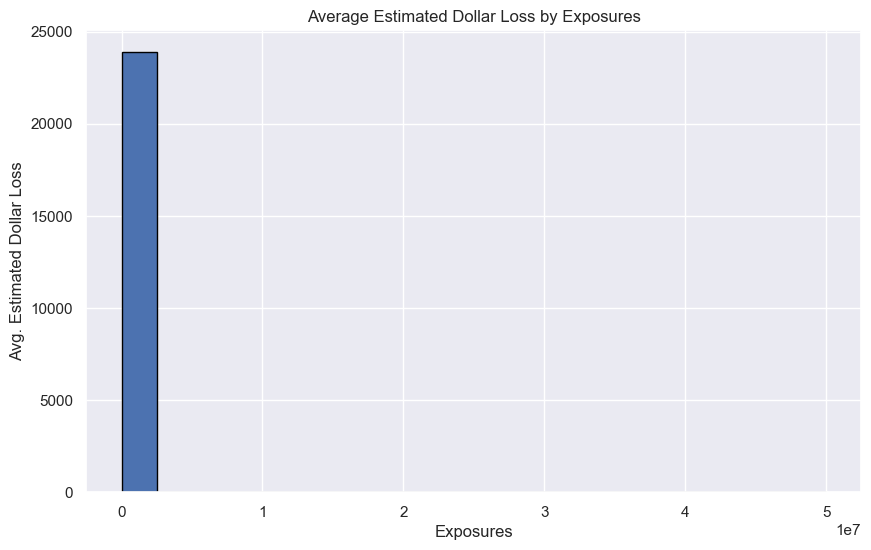

In [ ]:
import seaborn as sns
print("\nEstimated Dollar Loss by Sprinkler System Presence:")
print(df.groupby('Exposures')['Estimated_Dollar_Loss'].mean())
# Make a histogram of this
plt.figure(figsize=(10, 6))
plt.hist(df['Estimated_Dollar_Loss'], bins=20, edgecolor='black')
plt.xlabel('Exposures')
plt.ylabel('Avg. Estimated Dollar Loss')
plt.title('Average Estimated Dollar Loss by Exposures')

In [ ]:
import pandas as pd

# Load data
# data = pd.read_csv('toronto_fire_dataset.csv')  # Uncomment and specify file path

# Select only numerical columns
numerical_columns = df.select_dtypes(include=['number']).columns.tolist()

print("Numerical Columns:")
print(numerical_columns)

Numerical Columns:
['_id', 'Civilian_Casualties', 'Count_of_Persons_Rescued', 'Estimated_Dollar_Loss', 'Estimated_Number_Of_Persons_Displaced', 'Exposures', 'Incident_Ward', 'Latitude', 'Longitude', 'Number_of_responding_apparatus', 'Number_of_responding_personnel', 'TFS_Firefighter_Casualties']


Correlation Matrix:
                                       Civilian_Casualties  \
Civilian_Casualties                                      1   
Count_of_Persons_Rescued                                 0   
Estimated_Dollar_Loss                                    0   
Estimated_Number_Of_Persons_Displaced                    0   
Exposures                                               -0   
Incident_Ward                                           -0   
Latitude                                                -0   
Longitude                                               -0   
Number_of_responding_apparatus                           0   
Number_of_responding_personnel                           0   
TFS_Firefighter_Casualties                               0   

                                       Count_of_Persons_Rescued  \
Civilian_Casualties                                           0   
Count_of_Persons_Rescued                                      1   
Estimated_Dollar_Loss             

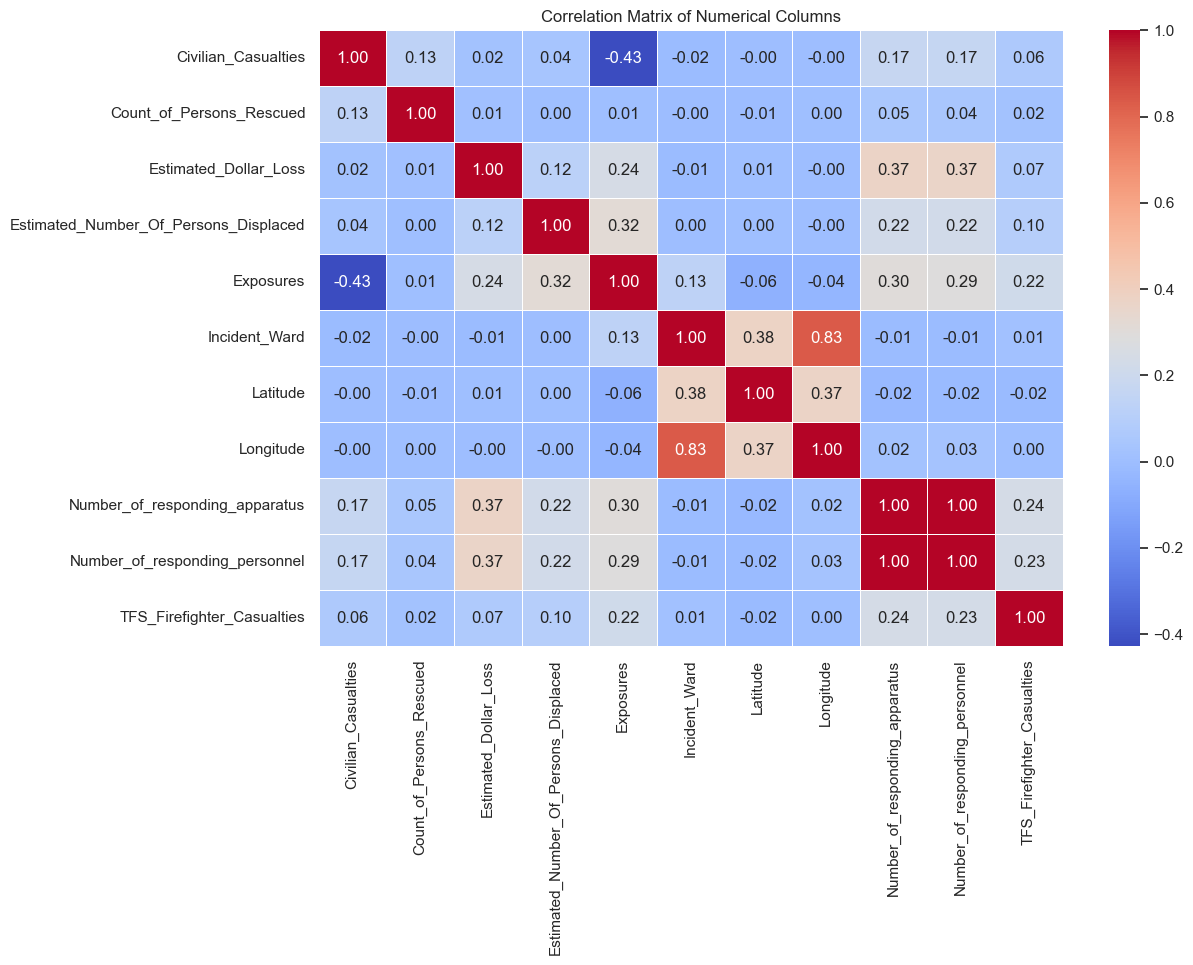

In [ ]:
# Select only the numerical columns
numerical_data = df.select_dtypes(include=['number']).drop(columns=['_id'], errors='ignore')

# Calculate correlation matrix on numerical data only
correlation_matrix = numerical_data.corr()

# Display the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix of Numerical Columns")
plt.show()

In [ ]:
df.head()


,_id,Area_of_Origin,Building_Status,Business_Impact,Civilian_Casualties,Count_of_Persons_Rescued,Estimated_Dollar_Loss,Estimated_Number_Of_Persons_Displaced,Exposures,Ext_agent_app_or_defer_time,...,Smoke_Alarm_at_Fire_Origin_Alarm_Failure,Smoke_Alarm_at_Fire_Origin_Alarm_Type,Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation,Smoke_Spread,Sprinkler_System_Operation,Sprinkler_System_Presence,Status_of_Fire_On_Arrival,TFS_Alarm_Time,TFS_Arrival_Time,TFS_Firefighter_Casualties
0,3399984,990 - Under Investigation,01 - Normal (no change),5 - May not resume operations,0,0,"50,000,000",800,NaN,2019-05-07T03:34:02,...,99 - Reason for inoperation undetermined,9 - Type undetermined,9 - Undetermined,8 - Entire Structure,8 - Not applicable - no sprinkler system present,3 - No sprinkler system,3 - Fire with smoke showing only - including v...,2019-05-07T03:24:09,2019-05-07T03:29:48,0
1,3420340,99 - Undetermined (formerly 98),03 - Under Construction,1 - No business interruption,0,0,"15,000,000",0,NaN,2021-10-05T22:06:54,...,98 - Not applicable: Alarm operated OR presenc...,9 - Type undetermined,9 - Undetermined,10 - Spread beyond building of origin,9 - Activation/operation undetermined,9 - Undetermined,"7 - Fully involved (total structure, vehicle, ...",2021-10-05T21:59:32,2021-10-05T22:05:39,0
2,3411787,83 - Electrical Systems,08 - Not Applicable,9 - Undetermined,0,0,"13,000,000",0,NaN,2011-03-18T17:05:00,...,98 - Not applicable: Alarm operated OR presenc...,8 - Not applicable - no smoke alarm or presenc...,"8 - Not applicable: No alarm, no persons present",99 - Undetermined,8 - Not applicable - no sprinkler system present,3 - No sprinkler system,9 - Unclassified,2011-03-18T16:49:47,2011-03-18T16:55:59,0
3,3411482,50 - Basement/cellar (not partitioned),01 - Normal (no change),9 - Undetermined,0,0,"10,000,000",0,NaN,2017-02-11T05:18:09,...,98 - Not applicable: Alarm operated OR presenc...,8 - Not applicable - no smoke alarm or presenc...,"8 - Not applicable: No alarm, no persons present",8 - Entire Structure,8 - Not applicable - no sprinkler system present,3 - No sprinkler system,3 - Fire with smoke showing only - including v...,2017-02-11T05:07:31,2017-02-11T05:12:13,0
4,3411499,"52 - HVAC Equipment Room (furnace room, water ...",01 - Normal (no change),5 - May not resume operations,0,0,"10,000,000",100,NaN,2017-02-14T09:29:00,...,98 - Not applicable: Alarm operated OR presenc...,4 - Interconnected,1 - All persons (at risk of injury) self evacu...,"4 - Spread beyond room of origin, same floor",9 - Activation/operation undetermined,9 - Undetermined,2 - Fire with no evidence from street,2017-02-14T09:22:30,2017-02-14T09:26:23,0
